In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X_train = pd.read_csv("X_train.csv").to_numpy()
Y_train = pd.read_csv("Y_train.csv").to_numpy().flatten()  # flatten to 1D for convenience
la = 1
batch_size_list = [10, 20, 50, 100]
step_size_list = [1e-2, 1e-3, 1e-4, 1e-5]
N_epoch = 500
f_star = 57.0410

n_samples, n_features = X_train.shape

for batch_size in batch_size_list:
    n_batches = n_samples // batch_size
    for step_size in step_size_list:
        beta = np.random.randn(n_features)
        b = np.random.randn()
        f = np.zeros(N_epoch)

        for epoch in range(N_epoch):
            perm = np.random.permutation(n_samples)
            X_perm = X_train[perm]
            Y_perm = Y_train[perm]

            for batch_idx in range(n_batches):
                start = batch_idx * batch_size
                end = start + batch_size
                x_batch = X_perm[start:end]
                y_batch = Y_perm[start:end]

                pred = x_batch.dot(beta) + b
                error = pred - y_batch

                grad_beta = (x_batch.T.dot(error) / batch_size) + la * beta
                grad_b = np.sum(error) / batch_size

                beta -= step_size * grad_beta
                b -= step_size * grad_b

            # Compute objective function f at epoch end
            pred_full = X_train.dot(beta) + b
            residual = pred_full - Y_train
            f[epoch] = (np.sum(residual**2) / (2 * n_samples)) + (la / 2) * np.sum(beta**2)

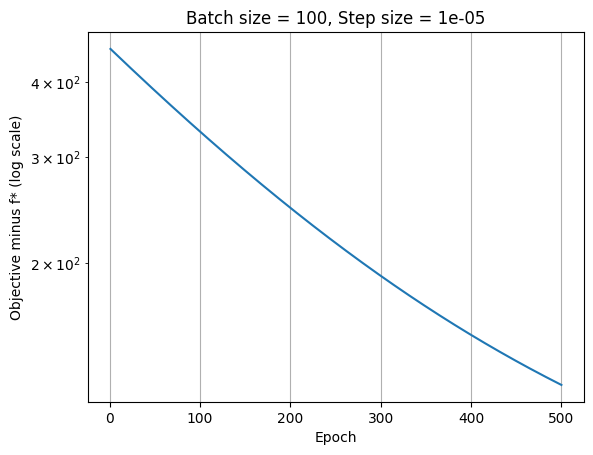

In [ ]:
plt.figure()
plt.semilogy(np.arange(1, N_epoch + 1), f - f_star)
plt.title(f"Batch size = {batch_size}, Step size = {step_size}")
plt.xlabel("Epoch")
plt.ylabel("Objective minus f* (log scale)")
plt.grid(True)



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

X_train = pd.read_csv("X_train.csv").to_numpy()
Y_train = pd.read_csv("Y_train.csv").to_numpy().flatten()
la = 0.02
step_size = 0.005
N_epoch = 10000
f_star = 49.9649
groups = [[0], [1], [2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12], [13, 14], [15], [16], [17]]

n_samples, n_features = X_train.shape

# --- Group LASSO ---
beta = np.random.randn(n_features)
b = np.random.randn()
f = np.zeros(N_epoch)

for i in range(N_epoch):
    pred = X_train.dot(beta) + b
    error = pred - Y_train

    grad_beta = (X_train.T.dot(error)) / n_samples
    grad_b = np.sum(error) / n_samples

    beta_prim = beta - step_size * grad_beta

    f[i] = 0  # reset for this iteration
    # Proximal operator for each group
    for group in groups:
        group_vec = beta_prim[group]
        norm_val = np.linalg.norm(group_vec)
        threshold = la * np.sqrt(len(group)) * step_size
        coeff = 1 - threshold / max(norm_val, threshold)
        beta[group] = coeff * group_vec
        f[i] += la * np.sqrt(len(group)) * np.linalg.norm(beta[group])

    f[i] += (np.sum(error**2) / (2 * n_samples))

    b -= step_size * grad_b

plt.figure()
plt.semilogy(np.arange(1, N_epoch + 1), f - f_star)
plt.title(f"Group LASSO, Lambda = {la}, Step size = {step_size}")
plt.xlabel("Epoch")
plt.ylabel("Objective minus f* (log scale)")
plt.grid(True)
plt.savefig(f"Group_LASSO_Lambda_{la}_Step_{step_size}.jpg")
plt.close()

for group in groups:
    print(f"Group {group}: {beta[group]}")

# --- LASSO ---
beta = np.random.randn(n_features)
b = np.random.randn()
f_LASSO = np.zeros(N_epoch)

for i in range(N_epoch):
    pred = X_train.dot(beta) + b
    error = pred - Y_train

    grad_beta = (X_train.T.dot(error)) / n_samples
    grad_b = np.sum(error) / n_samples

    beta_prim = beta - step_size * grad_beta

    norm_val = np.linalg.norm(beta_prim)
    threshold = la * np.sqrt(n_features) * step_size
    coeff = 1 - threshold / max(norm_val, threshold)
    beta = coeff * beta_prim

    f_LASSO[i] = la * np.sqrt(n_features) * np.linalg.norm(beta) + (np.sum(error**2) / (2 * n_samples))

    b -= step_size * grad_b

plt.figure()
plt.semilogy(np.arange(1, N_epoch + 1), f_LASSO - f_star)
plt.title(f"LASSO, Lambda = {la}, Step size = {step_size}")
plt.xlabel("Epoch")
plt.ylabel("Objective minus f* (log scale)")
plt.grid(True)
plt.savefig(f"LASSO_Lambda_{la}_Step_{step_size}.jpg")
plt.close()

print(beta)

# --- Accelerated Group LASSO ---
beta = np.random.randn(n_features)
beta_prev = beta.copy()
b = np.random.randn()
f_acc = np.zeros(N_epoch)

for i in range(N_epoch):
    pred = X_train.dot(beta) + b
    error = pred - Y_train

    grad_beta = (X_train.T.dot(error)) / n_samples
    grad_b = np.sum(error) / n_samples

    momentum = (i - 2) / (i + 1) if i > 0 else 0
    beta_prim = beta - step_size * grad_beta + momentum * (beta - beta_prev)
    beta_prev = beta.copy()

    f_acc[i] = 0
    for group in groups:
        group_vec = beta_prim[group]
        norm_val = np.linalg.norm(group_vec)
        threshold = la * np.sqrt(len(group)) * step_size
        coeff = 1 - threshold / max(norm_val, threshold)
        beta[group] = coeff * group_vec
        f_acc[i] += la * np.sqrt(len(group)) * np.linalg.norm(beta[group])

    f_acc[i] += (np.sum(error**2) / (2 * n_samples))

    b -= step_size * grad_b




Group [0]: [17.93304414]
Group [1]: [-1.54384892]
Group [2, 3, 4, 5, 6]: [-0.00132762 -0.0194062  -0.00112844 -0.00163674 -0.00108234]
Group [7, 8, 9, 10, 11, 12]: [ 0.56522991  0.51478595 -0.4157444  -0.04711256  0.76465943  0.25336224]
Group [13, 14]: [0.72719868 0.26425419]
Group [15]: [6.63970752]
Group [16]: [0.25529313]
Group [17]: [4.88895179]
[15.49283985 -1.6650591  -0.73214874  0.24460137 -1.47359301  2.0681625
  0.14228803  0.7471276   1.16634458 -0.47919631  1.14146974  1.98981994
  0.13888196  0.42937165  1.25638122  6.28452291  0.44203606  3.9489471 ]


Group [0]: [31.36718813]
Group [1]: [-1.43928469]
Group [2, 3, 4, 5, 6]: [-0. -0. -0. -0. -0.]
Group [7, 8, 9, 10, 11, 12]: [-1.78470007e-03 -1.98395196e-03 -2.02928977e-03 -2.09238533e-03
 -9.97237425e-05 -2.02910646e-03]
Group [13, 14]: [-0.  0.]
Group [15]: [9.28827506]
Group [16]: [-10.74568734]
Group [17]: [8.20124381]


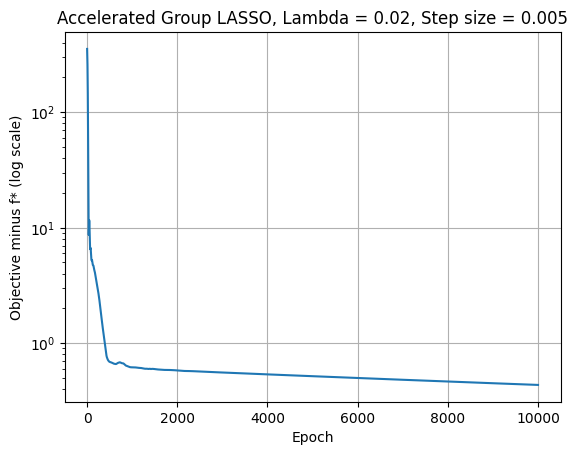

In [ ]:
plt.figure()
plt.semilogy(np.arange(1, N_epoch + 1), f_acc - f_star)
plt.title(f"Accelerated Group LASSO, Lambda = {la}, Step size = {step_size}")
plt.xlabel("Epoch")
plt.ylabel("Objective minus f* (log scale)")
plt.grid(True)



--- Scenario: BAU ---
BR: total_cons_em = 80.7947, sum(C)=0.0000, sum(P)=0.0000, sum(T)=0.0000
COOP: total_cons_em = 43.1764, SCC*emissions=2158.8190, sum(C)=745.3905, sum(P)=0.0000, sum(T)=0.0000
BR reductions r (rounded): [0. 0. 0. 0. 0. 0. 0.]
COOP reductions r (rounded): [1.    1.    1.    1.    0.556 0.242 0.256]

--- Scenario: CarbonTax_10 ---
BR: total_cons_em = 70.1353, sum(C)=53.3236, sum(P)=0.0000, sum(T)=701.3528
COOP: total_cons_em = 39.0117, SCC*emissions=1950.5828, sum(C)=974.4503, sum(P)=0.0000, sum(T)=390.1166
BR reductions r (rounded): [0.3   0.417 0.417 0.5   0.111 0.048 0.051]
COOP reductions r (rounded): [1.    1.    1.    1.    0.667 0.291 0.308]

--- Scenario: Domestic_Subsidy ---
BR: total_cons_em = 79.1708, sum(C)=2.0313, sum(P)=4.0625, sum(T)=0.0000
COOP: total_cons_em = 43.1764, SCC*emissions=2158.8188, sum(C)=745.3907, sum(P)=42.0000, sum(T)=0.0000
BR reductions r (rounded): [0.075 0.104 0.104 0.125 0.    0.    0.   ]
COOP reductions r (rounded): [1.    1.  

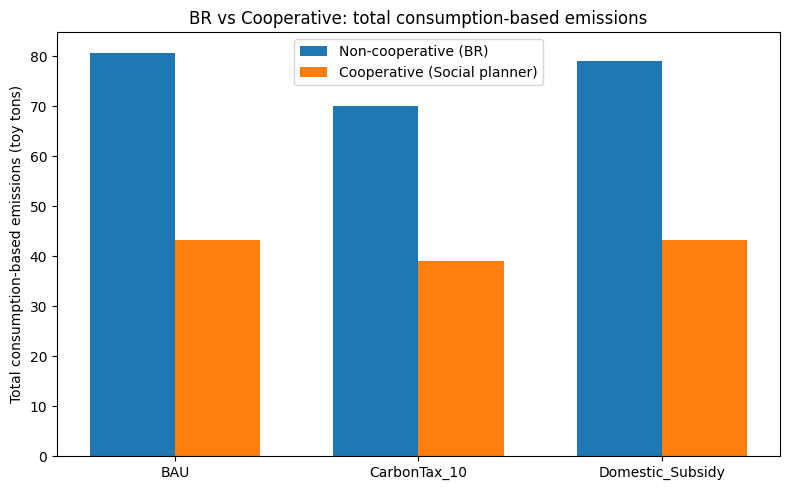

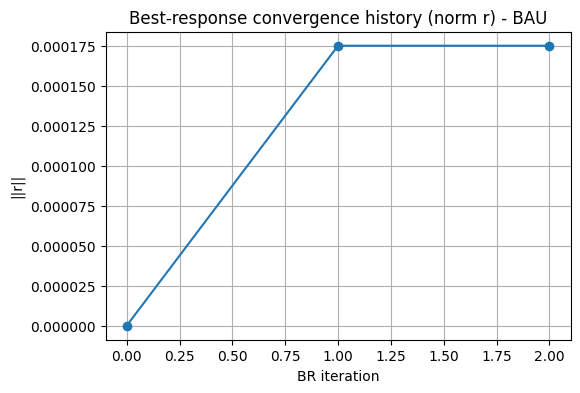

In [ ]:
"""
Fixed game-theory toy MRIO script with monetary-consistent costs and SCC.
- Best-response dynamics (approx Nash)
- Cooperative social planner (SLSQP)
- Scenario runs with prints + plots and objective decomposition
"""

import numpy as np
from scipy.optimize import minimize_scalar, minimize
import matplotlib.pyplot as plt

# -------------------------
# Synthetic MRIO-like data
# -------------------------
def make_synthetic_data():
    # Domestic sectors (J=4): Energy, Transport, Manufacturing, Agriculture
    J_dom = 4
    # Foreign regions (K=3): EU, Asia, Americas
    K_foreign = 3
    n_players = J_dom + K_foreign

    # Baseline direct emissions (tons/year) for each producer (toy numbers)
    e0_dom = np.array([10.0, 6.0, 8.0, 4.0])
    e0_foreign = np.array([30.0, 50.0, 40.0])
    e0 = np.concatenate([e0_dom, e0_foreign])

    # Consumption-side matrix A: fraction of consumer i's consumption supplied by producer j
    A = np.zeros((J_dom, n_players))
    dom_share = 0.6
    for i in range(J_dom):
        A[i, :J_dom] = dom_share / J_dom
        A[i, J_dom:] = (1 - dom_share) / K_foreign

    # consumption magnitudes per domestic consumer (toy units)
    c_dom = np.array([100.0, 80.0, 120.0, 60.0])

    # abatement cost params a_i (monetary per (ton^2)), moderate values so costs matter
    a = np.concatenate([np.array([1.0, 1.2, 0.9, 1.5]), np.array([0.8, 1.1, 1.3])])

    # baseline subsidies per ton (monetary per ton), zero by default
    s = np.zeros(n_players)

    # initial strategy
    r0 = np.zeros(n_players)

    return {
        "J_dom": J_dom,
        "K_foreign": K_foreign,
        "n": n_players,
        "e0": e0,
        "A": A,
        "c_dom": c_dom,
        "a": a,
        "s": s,
        "r0": r0,
    }

# -------------------------
# Emissions accounting
# -------------------------
def consumption_based_emissions(e0, r, A, c_dom):
    """
    Simple consumption accounting: consumer i assigned emissions = sum_j A[i,j] * e_prod[j]
    where e_prod[j] = e0[j] * (1 - r[j]).
    Returns (cons_by_consumer, total_cons_em, e_prod)
    """
    e_prod = e0 * (1 - r)
    cons_by_consumer = A.dot(e_prod)
    total_cons_em = cons_by_consumer.sum()
    return cons_by_consumer, total_cons_em, e_prod

# -------------------------
# Monetary-consistent payoff
# -------------------------
def player_payoffs(e0, r, A, c_dom, a, s, carbon_tax=0.0, import_tariff=None):
    """
    Monetary payoff U_i = -C_i + P_i - T_i
    C_i = a_i * (r_i * e0_i)^2    (monetary cost)
    P_i = s_i * (r_i * e0_i)      (monetary subsidy)
    T_i = carbon_tax * assigned_emissions (monetary penalty)
    """
    n = len(e0)
    cons_by_consumer, total_cons_em, e_prod = consumption_based_emissions(e0, r, A, c_dom)
    # assigned emissions to domestic consumption from each producer
    assigned = e_prod * A.sum(axis=0)

    C = a * (r * e0) ** 2
    P = s * (r * e0)

    T = np.zeros(n)
    if carbon_tax and carbon_tax != 0.0:
        T += carbon_tax * assigned
    if import_tariff is not None:
        T += import_tariff * assigned

    U = -C + P - T
    return U, assigned, total_cons_em, C.sum(), P.sum(), T.sum()

def carbon_tax_term(e0, r, A, c_dom, carbon_tax=0.0):
    if carbon_tax == 0.0:
        return 0.0
    _, _, eprod = consumption_based_emissions(e0, r, A, c_dom)
    assigned = eprod * A.sum(axis=0)
    return carbon_tax * assigned.sum()

# -------------------------
# Best-response dynamics
# -------------------------
def best_response_nash(e0, A, c_dom, a, s, r0=None, carbon_tax=0.0, import_tariff=None,
                       max_iters=200, tol=1e-4, verbose=False):
    n = len(e0)
    if r0 is None:
        r = np.zeros(n)
    else:
        r = r0.copy()

    history = [r.copy()]
    for it in range(max_iters):
        r_old = r.copy()
        for i in range(n):
            def neg_util_single(ri):
                r_temp = r.copy()
                r_temp[i] = ri
                U, _, _, _, _, _ = player_payoffs(e0, r_temp, A, c_dom, a, s, carbon_tax, import_tariff)
                return -U[i]
            res = minimize_scalar(neg_util_single, bounds=(0.0, 1.0), method='bounded', options={'xatol':1e-4})
            r[i] = res.x
        history.append(r.copy())
        diff = np.linalg.norm(r - r_old)
        if verbose:
            print(f"BR iter {it}: diff={diff:.6f}")
        if diff < tol:
            break
    U, assigned, total_cons_em, Csum, Psum, Tsum = player_payoffs(e0, r, A, c_dom, a, s, carbon_tax, import_tariff)
    return r, U, assigned, total_cons_em, Csum, Psum, Tsum, np.array(history)

# -------------------------
# Cooperative social planner (monetary objective with SCC)
# -------------------------
def cooperative_solution(e0, A, c_dom, a, s, carbon_tax=0.0, weight_cost=1.0, SCC=50.0):
    """
    Minimize objective = SCC * total_cons_em + weight_cost * sum_i a_i (r_i*e0_i)^2 - sum_i s_i (r_i*e0_i) + tax term
    SCC converts tons -> monetary units.
    """
    n = len(e0)

    def obj(r_vec):
        r_vec = np.clip(r_vec, 0.0, 1.0)
        _, total_cons_em, _ = consumption_based_emissions(e0, r_vec, A, c_dom)
        cost = np.sum(a * (r_vec * e0) ** 2)
        subsidy = np.sum(s * (r_vec * e0))
        tax_term = carbon_tax_term(e0, r_vec, A, c_dom, carbon_tax=carbon_tax)
        return SCC * total_cons_em + weight_cost * cost - subsidy + tax_term

    bounds = [(0.0, 1.0)] * n
    r0 = np.zeros(n)
    res = minimize(obj, r0, bounds=bounds, method='SLSQP', options={'ftol':1e-6, 'maxiter':500})
    r_opt = np.clip(res.x, 0.0, 1.0)
    U, assigned, total_cons_em, Csum, Psum, Tsum = player_payoffs(e0, r_opt, A, c_dom, a, s, carbon_tax)
    return r_opt, assigned, total_cons_em, Csum, Psum, Tsum, res

# -------------------------
# Scenario runner with prints and plots
# -------------------------
def run_scenarios_and_plot():
    data = make_synthetic_data()
    e0 = data["e0"]; A = data["A"]; c_dom = data["c_dom"]
    a = data["a"]; s_base = data["s"]; r0 = data["r0"]; n = data["n"]

    # reasonable scenario defaults
    scenarios = {
        "BAU": {"carbon_tax": 0.0, "import_tariff": None, "s": np.zeros(n), "SCC": 50.0},
        "CarbonTax_10": {"carbon_tax": 10.0, "import_tariff": None, "s": np.zeros(n), "SCC": 50.0},
        "Domestic_Subsidy": {"carbon_tax": 0.0, "import_tariff": None,
                            "s": np.concatenate([np.ones(4)*1.5, np.zeros(n-4)]), "SCC": 50.0},
    }

    results = {}
    for name, params in scenarios.items():
        print(f"\n--- Scenario: {name} ---")
        s_local = params.get("s", np.zeros(n))
        carbon_tax = params.get("carbon_tax", 0.0)
        SCC = params.get("SCC", 50.0)

        # Best-response (non-cooperative)
        r_br, U_br, assigned_br, total_cons_em_br, Cbr, Pbr, Tbr, history = best_response_nash(
            e0, A, c_dom, a, s_local, r0=r0, carbon_tax=carbon_tax, import_tariff=None,
            max_iters=200, tol=1e-5, verbose=False
        )

        # Cooperative (social planner)
        r_coop, assigned_coop, total_cons_em_coop, Ccoop, Pcoop, Tcoop, res = cooperative_solution(
            e0, A, c_dom, a, s_local, carbon_tax=carbon_tax, weight_cost=1.0, SCC=SCC
        )

        # Print summary numbers and decomposition for cooperative solution
        print(f"BR: total_cons_em = {total_cons_em_br:.4f}, sum(C)={Cbr:.4f}, sum(P)={Pbr:.4f}, sum(T)={Tbr:.4f}")
        print(f"COOP: total_cons_em = {total_cons_em_coop:.4f}, SCC*emissions={SCC*total_cons_em_coop:.4f}, sum(C)={Ccoop:.4f}, sum(P)={Pcoop:.4f}, sum(T)={Tcoop:.4f}")
        print(f"BR reductions r (rounded): {np.round(r_br,3)}")
        print(f"COOP reductions r (rounded): {np.round(r_coop,3)}")

        results[name] = {
            "BR": {"r": r_br, "total_cons_em": total_cons_em_br, "C": Cbr, "P": Pbr, "T": Tbr},
            "Coop": {"r": r_coop, "total_cons_em": total_cons_em_coop, "C": Ccoop, "P": Pcoop, "T": Tcoop},
            "history": history,
            "SCC": SCC
        }

    # Plot comparison of emissions (BR vs Coop)
    scenario_names = list(results.keys())
    br_vals = [results[k]["BR"]["total_cons_em"] for k in scenario_names]
    coop_vals = [results[k]["Coop"]["total_cons_em"] for k in scenario_names]

    x = np.arange(len(scenario_names))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(x - width/2, br_vals, width, label='Non-cooperative (BR)')
    ax.bar(x + width/2, coop_vals, width, label='Cooperative (Social planner)')
    ax.set_xticks(x)
    ax.set_xticklabels(scenario_names)
    ax.set_ylabel("Total consumption-based emissions (toy tons)")
    ax.legend()
    ax.set_title("BR vs Cooperative: total consumption-based emissions")
    plt.tight_layout()
    plt.show()

    # Plot one example of BR history (norm of r over iterations) for first scenario
    first = scenario_names[0]
    hist = results[first]["history"]
    norms = np.linalg.norm(hist, axis=1)
    plt.figure(figsize=(6,4))
    plt.plot(norms, marker='o')
    plt.xlabel("BR iteration")
    plt.ylabel("||r||")
    plt.title(f"Best-response convergence history (norm r) - {first}")
    plt.grid(True)
    plt.show()

    return results

# -------------------------
# Run if executed
# -------------------------
if __name__ == "__main__":
    results = run_scenarios_and_plot()


MC draws: 100%|██████████| 200/200 [00:08<00:00, 23.16it/s]



Scenario BAU:
 BR mean=80.568, std=6.436, 2.5%=69.240, 97.5%=92.569
 Coop mean=41.292, std=7.380, 2.5%=27.577, 97.5%=54.814

Scenario CarbonTax_10:
 BR mean=68.883, std=6.523, 2.5%=57.370, 97.5%=81.163
 Coop mean=36.977, std=7.643, 2.5%=22.897, 97.5%=51.479

Scenario Domestic_Subsidy:
 BR mean=78.786, std=6.440, 2.5%=67.489, 97.5%=90.799
 Coop mean=41.262, std=7.382, 2.5%=27.572, 97.5%=54.814


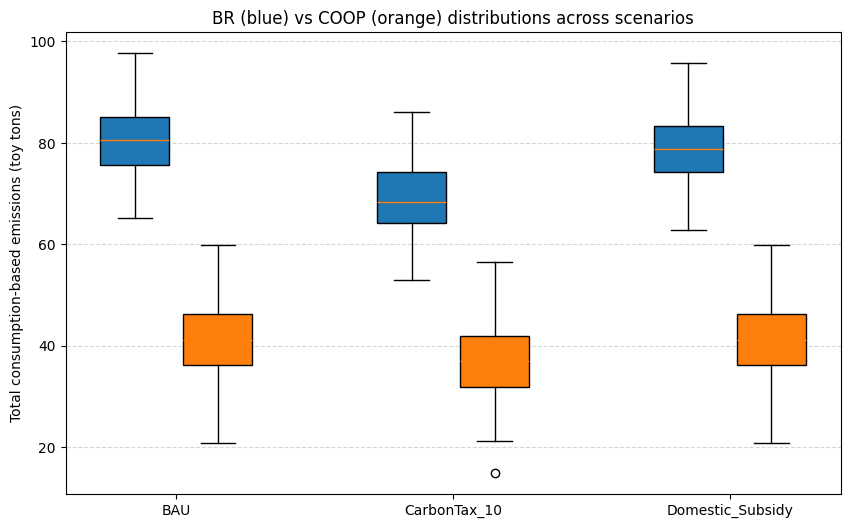

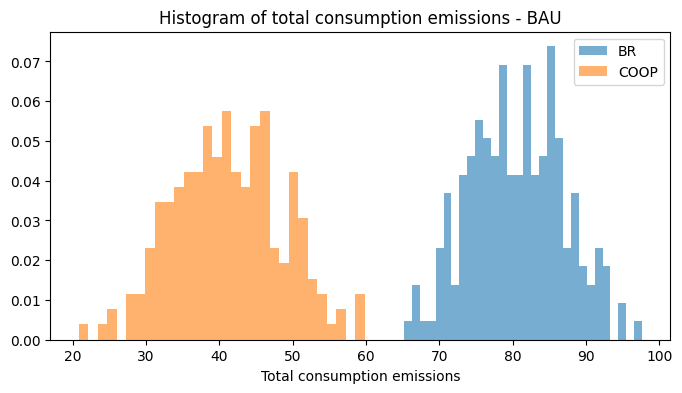

In [ ]:
"""
Uncertainty extension to the game-theory toy MRIO script.

- Adds Monte Carlo sampling for parameter uncertainty (e0, a, optional SCC).
- For each sample: solves Best-Response (BR) approx Nash and Cooperative (Coop) social planner.
- Aggregates distributions and plots comparisons.
"""

import numpy as np
from scipy.optimize import minimize_scalar, minimize
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

# ---------- base synthetic data (same as before) ----------
def make_synthetic_data():
    J_dom = 4
    K_foreign = 3
    n_players = J_dom + K_foreign

    e0_dom = np.array([10.0, 6.0, 8.0, 4.0])
    e0_foreign = np.array([30.0, 50.0, 40.0])
    e0 = np.concatenate([e0_dom, e0_foreign])

    A = np.zeros((J_dom, n_players))
    dom_share = 0.6
    for i in range(J_dom):
        A[i, :J_dom] = dom_share / J_dom
        A[i, J_dom:] = (1 - dom_share) / K_foreign

    c_dom = np.array([100.0, 80.0, 120.0, 60.0])

    a = np.concatenate([np.array([1.0, 1.2, 0.9, 1.5]), np.array([0.8, 1.1, 1.3])])
    s = np.zeros(n_players)
    r0 = np.zeros(n_players)

    return {"J_dom": J_dom, "K_foreign": K_foreign, "n": n_players,
            "e0": e0, "A": A, "c_dom": c_dom, "a": a, "s": s, "r0": r0}

# ---------- accounting, payoff, solvers (as before) ----------
def consumption_based_emissions(e0, r, A, c_dom):
    e_prod = e0 * (1 - r)
    cons_by_consumer = A.dot(e_prod)
    total_cons_em = cons_by_consumer.sum()
    return cons_by_consumer, total_cons_em, e_prod

def player_payoffs(e0, r, A, c_dom, a, s, carbon_tax=0.0, import_tariff=None):
    n = len(e0)
    cons_by_consumer, total_cons_em, e_prod = consumption_based_emissions(e0, r, A, c_dom)
    assigned = e_prod * A.sum(axis=0)
    C = a * (r * e0) ** 2
    P = s * (r * e0)
    T = np.zeros(n)
    if carbon_tax and carbon_tax != 0.0:
        T += carbon_tax * assigned
    if import_tariff is not None:
        T += import_tariff * assigned
    U = -C + P - T
    return U, assigned, total_cons_em, C.sum(), P.sum(), T.sum()

def carbon_tax_term(e0, r, A, c_dom, carbon_tax=0.0):
    if carbon_tax == 0.0:
        return 0.0
    _, _, eprod = consumption_based_emissions(e0, r, A, c_dom)
    assigned = eprod * A.sum(axis=0)
    return carbon_tax * assigned.sum()

def best_response_nash(e0, A, c_dom, a, s, r0=None, carbon_tax=0.0, import_tariff=None,
                       max_iters=200, tol=1e-5, verbose=False):
    n = len(e0)
    r = np.zeros(n) if r0 is None else r0.copy()
    history = [r.copy()]
    for it in range(max_iters):
        r_old = r.copy()
        for i in range(n):
            def neg_util_single(ri):
                r_temp = r.copy()
                r_temp[i] = ri
                U, _, _, _, _, _ = player_payoffs(e0, r_temp, A, c_dom, a, s, carbon_tax, import_tariff)
                return -U[i]
            res = minimize_scalar(neg_util_single, bounds=(0.0, 1.0), method='bounded', options={'xatol':1e-4})
            r[i] = res.x
        history.append(r.copy())
        if np.linalg.norm(r - r_old) < tol:
            break
    U, assigned, total_cons_em, Csum, Psum, Tsum = player_payoffs(e0, r, A, c_dom, a, s, carbon_tax, import_tariff)
    return r, U, assigned, total_cons_em, Csum, Psum, Tsum, np.array(history)

def cooperative_solution(e0, A, c_dom, a, s, carbon_tax=0.0, weight_cost=1.0, SCC=50.0):
    n = len(e0)
    def obj(r_vec):
        r_vec = np.clip(r_vec, 0.0, 1.0)
        _, total_cons_em, _ = consumption_based_emissions(e0, r_vec, A, c_dom)
        cost = np.sum(a * (r_vec * e0) ** 2)
        subsidy = np.sum(s * (r_vec * e0))
        tax_term = carbon_tax_term(e0, r_vec, A, c_dom, carbon_tax=carbon_tax)
        return SCC * total_cons_em + weight_cost * cost - subsidy + tax_term
    bounds = [(0.0, 1.0)] * n
    r0 = np.zeros(n)
    res = minimize(obj, r0, bounds=bounds, method='SLSQP', options={'ftol':1e-6, 'maxiter':500})
    r_opt = np.clip(res.x, 0.0, 1.0)
    U, assigned, total_cons_em, Csum, Psum, Tsum = player_payoffs(e0, r_opt, A, c_dom, a, s, carbon_tax)
    return r_opt, assigned, total_cons_em, Csum, Psum, Tsum, res

# ---------- Sampling helpers ----------
def sample_parameters(base_e0, base_a, sigma_e0=0.15, sigma_a=0.3, rng=None):
    """
    Sample positive parameters:
      - e0: truncated normal around base_e0 (or lognormal)
      - a: lognormal around base_a (so positive)
    sigma_e0, sigma_a are relative std-devs (fraction of base)
    """
    if rng is None:
        rng = np.random.default_rng()
    # e0: sample lognormal with mean ~ base_e0
    # transform base to log-space mean
    # choose lognormal parameters so mean=base and std = sigma_e0*base
    mu_e = np.log(base_e0**2 / np.sqrt((sigma_e0*base_e0)**2 + base_e0**2))
    sigma_e = np.sqrt(np.log(1 + (sigma_e0*base_e0)**2 / base_e0**2))
    e0_sample = rng.lognormal(mean=mu_e, sigma=sigma_e, size=base_e0.shape)
    # a: lognormal around base_a with relative sigma_a
    mu_a = np.log(base_a**2 / np.sqrt((sigma_a*base_a)**2 + base_a**2))
    sigma_a_param = np.sqrt(np.log(1 + (sigma_a*base_a)**2 / base_a**2))
    a_sample = rng.lognormal(mean=mu_a, sigma=sigma_a_param, size=base_a.shape)
    return e0_sample, a_sample

# ---------- Monte Carlo runner ----------
def monte_carlo_uncertainty(num_draws=500, sigma_e0=0.15, sigma_a=0.3, scenarios=None, verbose=True):
    data = make_synthetic_data()
    base_e0 = data["e0"]; base_a = data["a"]; A = data["A"]; c_dom = data["c_dom"]; s_base = data["s"]; r0 = data["r0"]; n = data["n"]
    rng = np.random.default_rng(12345)

    if scenarios is None:
        scenarios = {
            "BAU": {"carbon_tax": 0.0, "s": np.zeros(n), "SCC": 50.0},
            "CarbonTax_10": {"carbon_tax": 10.0, "s": np.zeros(n), "SCC": 50.0},
            "Domestic_Subsidy": {"carbon_tax": 0.0, "s": np.concatenate([np.ones(4)*1.5, np.zeros(n-4)]), "SCC": 50.0},
        }

    results = {name: {"BR_total": [], "COOP_total": [], "BR_C": [], "COOP_C": [], "BR_r": [], "COOP_r": []} for name in scenarios.keys()}

    iters = trange(num_draws, desc="MC draws") if verbose else range(num_draws)
    for k in iters:
        e0_samp, a_samp = sample_parameters(base_e0, base_a, sigma_e0=sigma_e0, sigma_a=sigma_a, rng=rng)
        for name, params in scenarios.items():
            s_local = params.get("s", np.zeros(n))
            carbon_tax = params.get("carbon_tax", 0.0)
            SCC = params.get("SCC", 50.0)

            # BR
            r_br, U_br, assigned_br, total_cons_em_br, Cbr, Pbr, Tbr, history = best_response_nash(
                e0_samp, A, c_dom, a_samp, s_local, r0=None, carbon_tax=carbon_tax, import_tariff=None,
                max_iters=200, tol=1e-5, verbose=False
            )
            # Coop
            r_coop, assigned_coop, total_cons_em_coop, Ccoop, Pcoop, Tcoop, res = cooperative_solution(
                e0_samp, A, c_dom, a_samp, s_local, carbon_tax=carbon_tax, weight_cost=1.0, SCC=SCC
            )

            results[name]["BR_total"].append(total_cons_em_br)
            results[name]["COOP_total"].append(total_cons_em_coop)
            results[name]["BR_C"].append(Cbr)
            results[name]["COOP_C"].append(Ccoop)
            results[name]["BR_r"].append(r_br)
            results[name]["COOP_r"].append(r_coop)

    # convert lists to arrays
    for name in results:
        for k in ["BR_total", "COOP_total", "BR_C", "COOP_C"]:
            results[name][k] = np.array(results[name][k])
        # r arrays -> (num_draws, n)
        results[name]["BR_r"] = np.stack(results[name]["BR_r"], axis=0)
        results[name]["COOP_r"] = np.stack(results[name]["COOP_r"], axis=0)
    return results

# ---------- plotting & summaries ----------
def summarize_and_plot_mc(results, show_hist=True):
    scenario_names = list(results.keys())

    # Summary prints
    for name in scenario_names:
        br = results[name]["BR_total"]
        coop = results[name]["COOP_total"]
        print(f"\nScenario {name}:")
        print(f" BR mean={br.mean():.3f}, std={br.std():.3f}, 2.5%={np.percentile(br,2.5):.3f}, 97.5%={np.percentile(br,97.5):.3f}")
        print(f" Coop mean={coop.mean():.3f}, std={coop.std():.3f}, 2.5%={np.percentile(coop,2.5):.3f}, 97.5%={np.percentile(coop,97.5):.3f}")

    # Boxplot comparison of total emissions across scenarios
    fig, ax = plt.subplots(figsize=(10,6))
    br_data = [results[n]["BR_total"] for n in scenario_names]
    coop_data = [results[n]["COOP_total"] for n in scenario_names]
    positions_br = np.arange(len(scenario_names))*2.0 - 0.3
    positions_coop = np.arange(len(scenario_names))*2.0 + 0.3
    bp1 = ax.boxplot(br_data, positions=positions_br, widths=0.5, patch_artist=True, boxprops=dict(facecolor='C0'))
    bp2 = ax.boxplot(coop_data, positions=positions_coop, widths=0.5, patch_artist=True, boxprops=dict(facecolor='C1'))
    ax.set_xticks(np.arange(len(scenario_names))*2.0)
    ax.set_xticklabels(scenario_names)
    ax.set_ylabel("Total consumption-based emissions (toy tons)")
    ax.set_title("BR (blue) vs COOP (orange) distributions across scenarios")
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.show()

    # Histograms for first scenario (overlay)
    first = scenario_names[0]
    plt.figure(figsize=(8,4))
    plt.hist(results[first]["BR_total"], bins=30, alpha=0.6, label='BR', density=True)
    plt.hist(results[first]["COOP_total"], bins=30, alpha=0.6, label='COOP', density=True)
    plt.legend()
    plt.title(f"Histogram of total consumption emissions - {first}")
    plt.xlabel("Total consumption emissions")
    plt.show()

# ---------- if run as script ----------
if __name__ == "__main__":
    # quick test: smaller Monte Carlo for demo
    results = monte_carlo_uncertainty(num_draws=200, sigma_e0=0.15, sigma_a=0.35, verbose=True)
    summarize_and_plot_mc(results)


=== Monte Carlo settings ===
num_draws = 500, seed = 12345
sigma_e0 = 0.15, sigma_a = 0.35
CI method = percentile (2.5%,97.5%)
subsidy_effect (coop) = 0.1
Python 3.11.13, numpy 2.0.2



MC draws: 100%|██████████| 500/500 [00:38<00:00, 12.94it/s]


Saved mc_results_snapshot.npz


Scenario BAU:
 BR mean=79.436, std=5.931, 2.5%=68.721, 97.5%=91.211
 Coop mean=39.365, std=7.189, 2.5%=25.709, 97.5%=53.738

Scenario CarbonTax_10:
 BR mean=67.766, std=6.199, 2.5%=56.849, 97.5%=79.964
 Coop mean=35.378, std=7.398, 2.5%=21.842, 97.5%=50.283

Scenario Domestic_Subsidy:
 BR mean=77.651, std=5.948, 2.5%=67.137, 97.5%=89.345
 Coop mean=39.321, std=7.184, 2.5%=25.709, 97.5%=53.738
Saved br_vs_coop_distribution.png


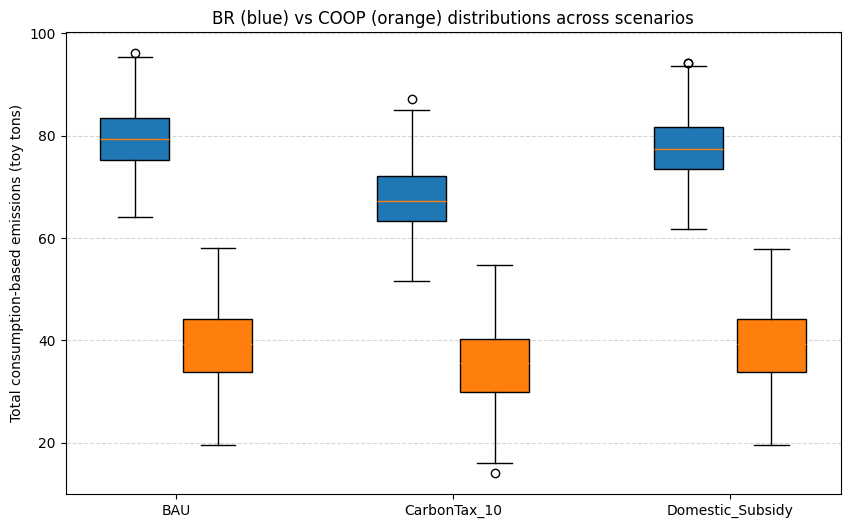

Saved total_consumption_emission_histogram.png


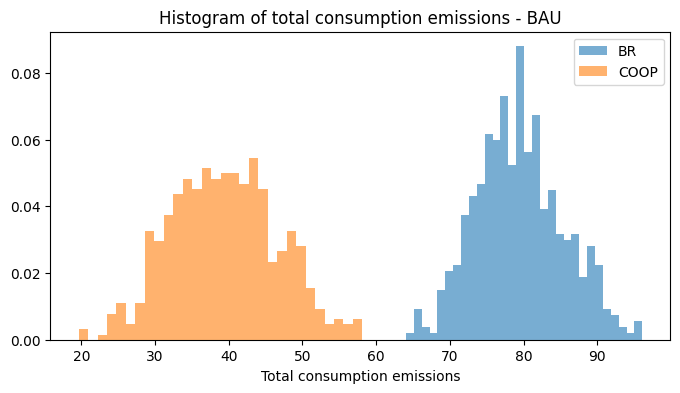

In [ ]:
"""
Strategic MRIO Monte Carlo script (updated)

Features:
- Nonlinear damage D(E) = kappa * E^2 included in players' utilities (strategic coupling).
- Cooperative solution: subsidies reduce marginal cost via subsidy_effect.
- Monte Carlo with reproducible seed, prints M, seed, sigma settings, CI method.
- CI: empirical percentiles (2.5%, 97.5%) by default; optional normal-approx.
- Saves figures and results (.npz).
"""
import numpy as np
from scipy.optimize import minimize_scalar, minimize
import matplotlib.pyplot as plt
from tqdm import trange
import sys, platform

# ---------------------------
# Synthetic base data
# ---------------------------
def make_synthetic_data(kappa=0.05):
    J_dom = 4
    K_foreign = 3
    n_players = J_dom + K_foreign

    e0_dom = np.array([10.0, 6.0, 8.0, 4.0])
    e0_foreign = np.array([30.0, 50.0, 40.0])
    e0 = np.concatenate([e0_dom, e0_foreign])

    A = np.zeros((J_dom, n_players))
    dom_share = 0.6
    for i in range(J_dom):
        A[i, :J_dom] = dom_share / J_dom
        A[i, J_dom:] = (1 - dom_share) / K_foreign

    c_dom = np.array([100.0, 80.0, 120.0, 60.0])

    a = np.concatenate([np.array([1.0, 1.2, 0.9, 1.5]), np.array([0.8, 1.1, 1.3])])
    s = np.zeros(n_players)
    r0 = np.zeros(n_players)

    # damage share for each player (how much of global damage they internalize)
    gamma = np.ones(n_players) / n_players  # uniform by default; can be heterogeneous
    return {"J_dom": J_dom, "K_foreign": K_foreign, "n": n_players,
            "e0": e0, "A": A, "c_dom": c_dom, "a": a, "s": s, "r0": r0,
            "gamma": gamma, "kappa": kappa}

# ---------------------------
# Emissions accounting
# ---------------------------
def consumption_based_emissions(e0, r, A, c_dom):
    e_prod = e0 * (1 - r)
    cons_by_consumer = A.dot(e_prod)
    total_cons_em = cons_by_consumer.sum()
    return cons_by_consumer, total_cons_em, e_prod

# ---------------------------
# Payoffs with nonlinear damage D(E) = kappa * E^2
# ---------------------------
def player_payoffs(e0, r, A, c_dom, a, s, gamma, kappa,
                   carbon_tax=0.0, import_tariff=None):
    n = len(e0)
    cons_by_consumer, total_cons_em, e_prod = consumption_based_emissions(e0, r, A, c_dom)
    assigned = e_prod * A.sum(axis=0)

    C = a * (r * e0) ** 2            # private abatement costs (vector)
    P = s * (r * e0)                 # subsidies/payoffs (vector)
    T = np.zeros(n)
    if carbon_tax and carbon_tax != 0.0:
        T += carbon_tax * assigned
    if import_tariff is not None:
        T += import_tariff * assigned

    # damage term - strategic coupling: each player's utility reduced by gamma_i * kappa * (total_cons_em)^2
    D_vec = gamma * kappa * (total_cons_em ** 2)

    U = -C + P - T - D_vec
    return U, assigned, total_cons_em, C.sum(), P.sum(), T.sum(), D_vec.sum()

# ---------------------------
# Best-response (iterated BR) solver
# ---------------------------
def best_response_nash(e0, A, c_dom, a, s, gamma, kappa,
                       r0=None, carbon_tax=0.0, import_tariff=None,
                       max_iters=300, tol=1e-6, verbose=False):
    n = len(e0)
    r = np.zeros(n) if r0 is None else r0.copy()
    history = [r.copy()]
    for it in range(max_iters):
        r_old = r.copy()
        for i in range(n):
            def neg_util_single(ri):
                r_temp = r.copy()
                r_temp[i] = ri
                U, *_ = player_payoffs(e0, r_temp, A, c_dom, a, s, gamma, kappa,
                                       carbon_tax, import_tariff)
                return -U[i]
            res = minimize_scalar(neg_util_single, bounds=(0.0, 1.0), method='bounded', options={'xatol':1e-6})
            r[i] = float(res.x)
        history.append(r.copy())
        if np.linalg.norm(r - r_old) < tol:
            break
    U, assigned, total_cons_em, Csum, Psum, Tsum, Dsum = player_payoffs(
        e0, r, A, c_dom, a, s, gamma, kappa, carbon_tax, import_tariff)
    return r, U, assigned, total_cons_em, Csum, Psum, Tsum, Dsum, np.array(history)

# ---------------------------
# Cooperative solver (social planner) with subsidy_effect
# ---------------------------
def cooperative_solution(e0, A, c_dom, a, s, gamma, kappa,
                         carbon_tax=0.0, weight_cost=1.0, SCC=50.0, subsidy_effect=0.1):
    n = len(e0)
    # Effective abatement cost parameters: subsidies reduce marginal cost
    a_eff = a * (1 - subsidy_effect * s)

    def obj(r_vec):
        r_vec = np.clip(r_vec, 0.0, 1.0)
        _, total_cons_em, _ = consumption_based_emissions(e0, r_vec, A, c_dom)
        cost = np.sum(a_eff * (r_vec * e0) ** 2)
        tax_term = carbon_tax * np.sum(e0 * (1 - r_vec) * A.sum(axis=0))
        damage = np.sum(gamma * kappa * (total_cons_em ** 2))
        subsidy_cost = np.sum(s * (r_vec * e0))
        return SCC * total_cons_em + weight_cost * cost + subsidy_cost_weight * subsidy_cost + tax_term

    bounds = [(0.0, 1.0)] * n
    res = minimize(obj, np.zeros(n), bounds=bounds, method='SLSQP',
                   options={'ftol':1e-7, 'maxiter':1000})
    r_opt = np.clip(res.x, 0.0, 1.0)
    U, assigned, total_cons_em, Csum, Psum, Tsum, Dsum = player_payoffs(
        e0, r_opt, A, c_dom, a_eff, s, gamma, kappa, carbon_tax)
    return r_opt, assigned, total_cons_em, Csum, Psum, Tsum, Dsum, res

# ---------------------------
# Sampling helpers (lognormal)
# ---------------------------
def lognormal_params_from_mean_std(mean, rel_std):
    sigma_rel = max(1e-12, rel_std)
    sigma_log = np.sqrt(np.log(1 + sigma_rel**2))
    mu_log = np.log(mean) - 0.5 * sigma_log**2
    return mu_log, sigma_log

def sample_parameters(base_e0, base_a, sigma_e0=0.15, sigma_a=0.3, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    mu_e, s_e = lognormal_params_from_mean_std(base_e0, sigma_e0)
    e0_sample = rng.lognormal(mean=mu_e, sigma=s_e, size=base_e0.shape)
    mu_a, s_a = lognormal_params_from_mean_std(base_a, sigma_a)
    a_sample = rng.lognormal(mean=mu_a, sigma=s_a, size=base_a.shape)
    return e0_sample, a_sample

# ---------------------------
# Monte Carlo runner
# ---------------------------
def monte_carlo_uncertainty(num_draws=500, sigma_e0=0.15, sigma_a=0.3, scenarios=None,
                            verbose=True, seed=12345, subsidy_effect=0.1):
    # metadata print
    print("=== Monte Carlo settings ===")
    print(f"num_draws = {num_draws}, seed = {seed}")
    print(f"sigma_e0 = {sigma_e0}, sigma_a = {sigma_a}")
    print(f"CI method = percentile (2.5%,97.5%)")
    print(f"subsidy_effect (coop) = {subsidy_effect}")
    print(f"Python {platform.python_version()}, numpy {np.__version__}")
    print("============================\n")

    data = make_synthetic_data()
    base_e0 = data["e0"]; base_a = data["a"]; A = data["A"]; c_dom = data["c_dom"]; s_base = data["s"]; r0 = data["r0"]
    gamma = data["gamma"]; kappa = data["kappa"]; n = data["n"]
    rng = np.random.default_rng(seed)

    if scenarios is None:
        scenarios = {
            "BAU": {"carbon_tax": 0.0, "s": np.zeros(n), "SCC": 50.0},
            "CarbonTax_10": {"carbon_tax": 10.0, "s": np.zeros(n), "SCC": 50.0},
            "Domestic_Subsidy": {"carbon_tax": 0.0, "s": np.concatenate([np.ones(4)*1.5, np.zeros(n-4)]), "SCC": 50.0},
        }

    results = {name: {"BR_total": [], "COOP_total": [], "BR_r": [], "COOP_r": []} for name in scenarios.keys()}

    iters = trange(num_draws, desc="MC draws") if verbose else range(num_draws)
    for k in iters:
        e0_samp, a_samp = sample_parameters(base_e0, base_a, sigma_e0=sigma_e0, sigma_a=sigma_a, rng=rng)
        for name, params in scenarios.items():
            s_local = params.get("s", np.zeros(n))
            carbon_tax = params.get("carbon_tax", 0.0)
            SCC = params.get("SCC", 50.0)

            # BR
            r_br, U_br, assigned_br, total_cons_em_br, Cbr, Pbr, Tbr, Dbr, history = best_response_nash(
                e0_samp, A, c_dom, a_samp, s_local, gamma, kappa, r0=None, carbon_tax=carbon_tax,
                import_tariff=None, max_iters=300, tol=1e-6, verbose=False
            )
            # Coop
            r_coop, assigned_coop, total_cons_em_coop, Ccoop, Pcoop, Tcoop, Dcoop, res = cooperative_solution(
                e0_samp, A, c_dom, a_samp, s_local, gamma, kappa, carbon_tax=carbon_tax, weight_cost=1.0, SCC=SCC,
                subsidy_effect=subsidy_effect
            )

            results[name]["BR_total"].append(total_cons_em_br)
            results[name]["COOP_total"].append(total_cons_em_coop)
            results[name]["BR_r"].append(r_br)
            results[name]["COOP_r"].append(r_coop)

    # to arrays
    for name in results:
        results[name]["BR_total"] = np.array(results[name]["BR_total"])
        results[name]["COOP_total"] = np.array(results[name]["COOP_total"])
        results[name]["BR_r"] = np.stack(results[name]["BR_r"], axis=0)
        results[name]["COOP_r"] = np.stack(results[name]["COOP_r"], axis=0)

    # save a reproducible snapshot
    np.savez("mc_results_snapshot.npz", results=results, seed=seed, num_draws=num_draws,
             sigma_e0=sigma_e0, sigma_a=sigma_a, subsidy_effect=subsidy_effect)
    print("Saved mc_results_snapshot.npz\n")

    return results

# ---------------------------
# Plot & summarize
# ---------------------------
def summarize_and_plot_mc(results, save_figs=True, ci_method="percentile"):
    scenario_names = list(results.keys())

    # Summary prints + CI (percentile)
    for name in scenario_names:
        br = results[name]["BR_total"]
        coop = results[name]["COOP_total"]
        M = br.size
        if ci_method == "percentile":
            br_ci = np.percentile(br, [2.5, 97.5])
            coop_ci = np.percentile(coop, [2.5, 97.5])
        else:
            # normal approx
            br_se = br.std(ddof=1)/np.sqrt(M)
            coop_se = coop.std(ddof=1)/np.sqrt(M)
            br_ci = (br.mean() - 1.96*br_se, br.mean() + 1.96*br_se)
            coop_ci = (coop.mean() - 1.96*coop_se, coop.mean() + 1.96*coop_se)

        print(f"\nScenario {name}:")
        print(f" BR mean={br.mean():.3f}, std={br.std():.3f}, 2.5%={br_ci[0]:.3f}, 97.5%={br_ci[1]:.3f}")
        print(f" Coop mean={coop.mean():.3f}, std={coop.std():.3f}, 2.5%={coop_ci[0]:.3f}, 97.5%={coop_ci[1]:.3f}")

    # Boxplot comparison of total emissions across scenarios
    fig, ax = plt.subplots(figsize=(10,6))
    br_data = [results[n]["BR_total"] for n in scenario_names]
    coop_data = [results[n]["COOP_total"] for n in scenario_names]
    positions_br = np.arange(len(scenario_names))*2.0 - 0.3
    positions_coop = np.arange(len(scenario_names))*2.0 + 0.3
    bp1 = ax.boxplot(br_data, positions=positions_br, widths=0.5, patch_artist=True, boxprops=dict(facecolor='C0'))
    bp2 = ax.boxplot(coop_data, positions=positions_coop, widths=0.5, patch_artist=True, boxprops=dict(facecolor='C1'))
    ax.set_xticks(np.arange(len(scenario_names))*2.0)
    ax.set_xticklabels(scenario_names)
    ax.set_ylabel("Total consumption-based emissions (toy tons)")
    ax.set_title("BR (blue) vs COOP (orange) distributions across scenarios")
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    if save_figs:
        fig.savefig("br_vs_coop_distribution.png", dpi=200, bbox_inches='tight')
        print("Saved br_vs_coop_distribution.png")
    plt.show()

    # Histograms for first scenario (overlay)
    first = scenario_names[0]
    plt.figure(figsize=(8,4))
    plt.hist(results[first]["BR_total"], bins=30, alpha=0.6, label='BR', density=True)
    plt.hist(results[first]["COOP_total"], bins=30, alpha=0.6, label='COOP', density=True)
    plt.legend()
    plt.title(f"Histogram of total consumption emissions - {first}")
    plt.xlabel("Total consumption emissions")
    if save_figs:
        plt.savefig("total_consumption_emission_histogram.png", dpi=200, bbox_inches='tight')
        print("Saved total_consumption_emission_histogram.png")
    plt.show()

# ---------------------------
# Convergence diagnostic helper
# ---------------------------
def convergence_diagnostic(M_list=[200,500,1000,2000], sigma_e0=0.15, sigma_a=0.35, seed=12345):
    print("Running convergence diagnostic for different M values:")
    for M in M_list:
        results = monte_carlo_uncertainty(num_draws=M, sigma_e0=sigma_e0, sigma_a=sigma_a, verbose=False, seed=seed)
        br_mean = results["BAU"]["BR_total"].mean()
        br_ci = np.percentile(results["BAU"]["BR_total"], [2.5,97.5])
        print(f" M={M:5d} | BAU BR mean={br_mean:.3f} | CI=[{br_ci[0]:.3f},{br_ci[1]:.3f}]")

# ---------------------------
# Run (example)
# ---------------------------
if __name__ == "__main__":
    # Quick demo run (adjust num_draws for full results)
    M = 500
    seed = 12345
    sigma_e0 = 0.15
    sigma_a = 0.35
    subsidy_effect = 0.1

    results = monte_carlo_uncertainty(num_draws=M, sigma_e0=sigma_e0, sigma_a=sigma_a,
                                      verbose=True, seed=seed, subsidy_effect=subsidy_effect)
    summarize_and_plot_mc(results, save_figs=True, ci_method="percentile")

    # optional: run convergence diagnostic (comment/uncomment as needed)
    # convergence_diagnostic([200,500,1000], sigma_e0=sigma_e0, sigma_a=sigma_a, seed=seed)


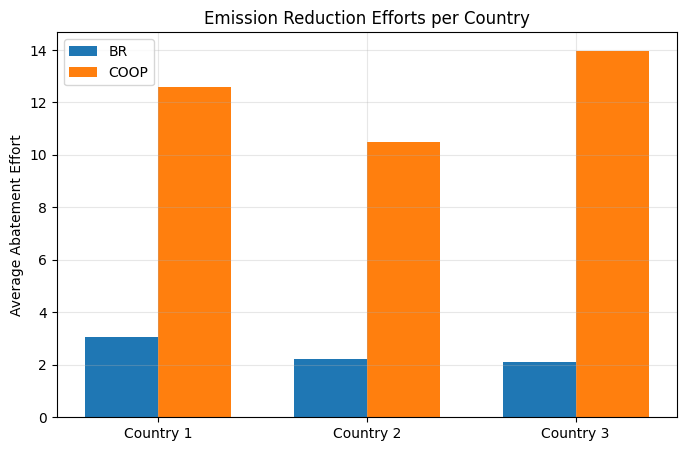

BAU: BR: mean=7.417, std=0.553, 2.5%=6.401
COOP: mean=37.047, std=2.533, 2.5%=32.092


In [ ]:
import numpy as np
from numpy.linalg import solve, LinAlgError
import matplotlib.pyplot as plt

# ---------- PARAMETERS ----------
n = 3  # number of countries
base_a = 8.0
base_b = 0.05
base_k = np.array([1.0, 1.2, 0.9, 1.5, 0.8])[:n]

# Option A: heterogeneous private valuation of shared benefit
# (beta < 1 means countries undervalue the total benefit)
base_beta = np.array([0.4, 0.35, 0.25, 0.4, 0.3])[:n]

# Option B: social cost multiplier for cooperative optimization
SCC = 1.8  # > 1 means social planner values environmental benefit more

n_sims = 2000
rng = np.random.default_rng(0)

# ---------- ANALYTICAL SOLVERS ----------
def solve_nash_linear(a, b, k, beta):
    """Solve Nash equilibrium (BR) using first-order conditions."""
    M = np.diag(k) + b * np.outer(beta, np.ones_like(beta))
    rhs = beta * a
    return solve(M, rhs)

def solve_cooperative_linear(a, b, k):
    """Solve Cooperative optimum using first-order conditions."""
    M = np.diag(k) + b * np.ones((len(k), len(k)))
    rhs = np.ones(len(k)) * a
    return solve(M, rhs)

# ---------- CONSTRAINED SOLVERS (for fallback if needed) ----------
from scipy.optimize import minimize

def constrained_nash(a, b, k, beta):
    n = len(k)
    def obj(x):
        S = np.sum(x)
        return -np.sum(beta*(a*S - 0.5*b*S**2) - 0.5*k*x**2)
    bounds = [(0, None)] * n
    return minimize(obj, np.ones(n), bounds=bounds).x

def constrained_cooperative(a, b, k):
    n = len(k)
    def obj(x):
        S = np.sum(x)
        return -(a*S - 0.5*b*S**2 - 0.5*np.sum(k*x**2))
    bounds = [(0, None)] * n
    return minimize(obj, np.ones(n), bounds=bounds).x


# ---------- MOnTO Carlo ----------


# 1. Total consumption emission histogram
# Assuming consumption emissions = a proxy like (baseline consumption - abatement)
# For simplicity: baseline consumption = a_s * k_s (randomized), store from sims
baseline_consumptions = []
br_vals, coop_vals = [], []
br_efforts, coop_efforts = [], []
baseline_consumptions = []
total_emissions_br = []
total_emissions_coop = []

for _ in range(n_sims):
    a_s = base_a + rng.normal(0, 0.5)
    b_s = max(0.01, base_b + rng.normal(0, 0.005))
    k_s = np.clip(base_k + rng.normal(0, 0.05, size=n), 0.1, None)
    beta_s = np.clip(base_beta + rng.normal(0, 0.02, size=n), 0.05, None)

    a_coop = SCC * a_s

    try:
        x_br = solve_nash_linear(a_s, b_s, k_s, beta_s)
    except LinAlgError:
        x_br = constrained_nash(a_s, b_s, k_s, beta_s)

    try:
        x_coop = solve_cooperative_linear(a_coop, b_s, k_s)
    except LinAlgError:
        x_coop = constrained_cooperative(a_coop, b_s, k_s)

    br_vals.append(np.sum(x_br))
    coop_vals.append(np.sum(x_coop))

    br_efforts.append(x_br)
    coop_efforts.append(x_coop)

    # Simple consumption-emission model: emissions = baseline - abatement
    baseline = a_s * k_s
    emissions_br = baseline - x_br
    baseline_consumptions.append(np.sum(baseline))
    total_emissions_br.append(np.sum(emissions_br))
    emissions_coop = baseline - x_coop  # could also compare coop
    total_emissions_coop.append(np.sum(emissions_coop))

br_vals = np.array(br_vals)
coop_vals = np.array(coop_vals)
br_efforts = np.array(br_efforts)
coop_efforts = np.array(coop_efforts)
baseline_consumptions = np.array(baseline_consumptions)
total_emissions_br = np.array(total_emissions_br)
total_emissions_coop = np.array(total_emissions_br)




# 2. Distribution of emission‐reduction efforts per country
plt.figure(figsize=(8,5))
positions = np.arange(n)
width = 0.35
plt.bar(positions - width/2, np.mean(br_efforts, axis=0), width, label="BR")
plt.bar(positions + width/2, np.mean(coop_efforts, axis=0), width, label="COOP")
plt.xticks(positions, [f"Country {i+1}" for i in range(n)])
plt.ylabel("Average Abatement Effort")
plt.title("Emission Reduction Efforts per Country")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---------- SUMMARY ----------
def summarize(name, data):
    mean = np.mean(data)
    std = np.std(data)
    p2_5 = np.percentile(data, 2.5)
    print(f"{name}: mean={mean:.3f}, std={std:.3f}, 2.5%={p2_5:.3f}")

summarize("BAU: BR", br_vals)
summarize("COOP", coop_vals)

In [ ]:
br_vals.size

2000

In [ ]:
# Histogram of total consumption emissions for BR and COOP together
total_emissions_coop = np.sum(baseline_consumptions * (1 - coop_efforts), axis=1)
total_emissions_br = np.sum(baseline_consumptions * (1 - br_efforts), axis=1)
plt.figure(figsize=(7,5))
plt.hist(total_emissions_br, bins=30, alpha=0.6, label="BR", color="steelblue", edgecolor="black")
plt.hist(total_emissions_coop, bins=30, alpha=0.6, label="COOP", color="orange", edgecolor="black")
plt.xlabel("Total Consumption Emissions")
plt.ylabel("Frequency")
plt.title("Histogram of Total Consumption Emissions: BR vs COOP")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


ValueError: operands could not be broadcast together with shapes (2000,) (2000,5) 

=== Monte Carlo settings ===
num_draws = 1000, seed = 12345
sigma_e0 = 0.15, sigma_a = 0.35
subsidy_effect = 0.4, subsidy_cost_weight = 0.05
CI method = empirical percentile (2.5%,97.5%)
Python 3.11.13, numpy 2.0.2



MC draws: 100%|██████████| 1000/1000 [01:12<00:00, 13.79it/s]


Saved mc_results_snapshot.npz


Scenario BAU:
 BR mean=134.857, std=9.888, 2.5%=117.756, 97.5%=155.216
 Coop mean=42.660, std=13.195, 2.5%=17.804, 97.5%=67.959

Scenario CarbonTax_10:
 BR mean=102.728, std=10.700, 2.5%=83.422, 97.5%=124.582
 Coop mean=34.738, std=13.479, 2.5%=9.725, 97.5%=60.884

Scenario Domestic_Subsidy:
 BR mean=131.836, std=9.936, 2.5%=114.523, 97.5%=152.620
 Coop mean=42.657, std=13.194, 2.5%=17.804, 97.5%=67.958
Saved br_vs_coop_distribution.png


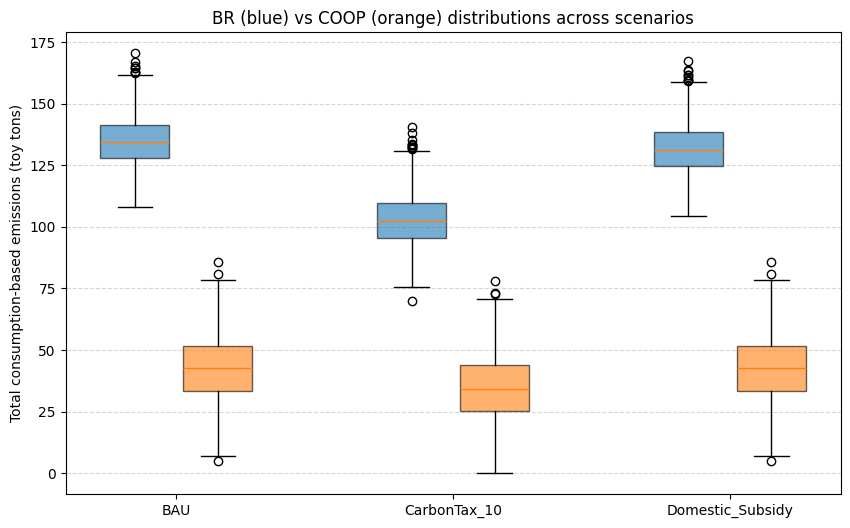

Saved total_consumption_emission_histogram.png


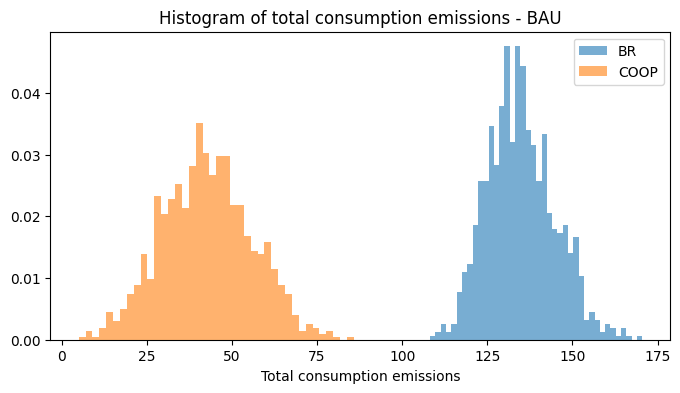

In [ ]:
"""
Strategic MRIO Monte Carlo script (updated)

Changes made:
- subsidy_cost_weight: planner treats subsidies as a (positive) budget cost
- Global nonlinear damage D(E) = kappa * E^2 is included in each player's utility
  (weighted by gamma_i), which creates genuine strategic coupling in BR.
- Cooperative objective includes subsidy cost weighted by subsidy_cost_weight.
- Default Monte Carlo draws M=1000 (can be changed).
- Saves results snapshot and figures.
"""

import numpy as np
from scipy.optimize import minimize_scalar, minimize
import matplotlib.pyplot as plt
from tqdm import trange
import platform

# ---------------------------
# Synthetic base data
# ---------------------------
def make_synthetic_data(kappa=0.05):
    J_dom = 4
    K_foreign = 3
    n_players = J_dom + K_foreign

    e0_dom = np.array([10.0, 6.0, 8.0, 4.0])
    e0_foreign = np.array([30.0, 50.0, 40.0])
    e0 = np.concatenate([e0_dom, e0_foreign])

    # square (n x n) MRIO: rows = consumers, cols = producers
    A = np.zeros((n_players, n_players))
    dom_share = 0.6
    for j in range(J_dom):
        # consumer j imports from domestic producers (first J_dom) and foreign (rest)
        A[j, :J_dom] = dom_share / J_dom
        A[j, J_dom:] = (1 - dom_share) / K_foreign
    # consumers beyond J_dom (if any) set as same pattern for simplicity
    # for this toy example we only consider J_dom consumers, but define shape n x n for clarity:
    for j in range(J_dom, n_players):
        A[j, :] = A[j % J_dom, :]

    c_dom = np.array([100.0, 80.0, 120.0, 60.0])

    a = np.concatenate([np.array([1.0, 1.2, 0.9, 1.5]), np.array([0.8, 1.1, 1.3])])
    s = np.zeros(n_players)
    r0 = np.zeros(n_players)

    # damage share for each player (how much of global damage they internalize)
    gamma = np.ones(n_players) / n_players  # uniform by default

    return {"J_dom": J_dom, "K_foreign": K_foreign, "n": n_players,
            "e0": e0, "A": A, "c_dom": c_dom, "a": a, "s": s, "r0": r0,
            "gamma": gamma, "kappa": kappa}

# ---------------------------
# Emissions accounting
# ---------------------------
def consumption_based_emissions(e0, r, A, c_dom=None):
    e_prod = e0 * (1 - r)
    cons_by_consumer = A.dot(e_prod)
    total_cons_em = cons_by_consumer.sum()
    return cons_by_consumer, total_cons_em, e_prod

# ---------------------------
# Payoffs including damage
# ---------------------------
def player_payoffs(e0, r, A, c_dom, a, s, gamma, kappa,
                   carbon_tax=0.0, import_tariff=None):
    n = len(e0)
    cons_by_consumer, total_cons_em, e_prod = consumption_based_emissions(e0, r, A, c_dom)
    # assigned emissions for producers (sum of column of A gives fraction allocated)
    assigned = e_prod * A.sum(axis=0)

    C = a * (r * e0) ** 2            # private abatement costs (vector)
    P = s * (r * e0)                 # subsidies/payoffs (vector)
    T = np.zeros(n)
    if carbon_tax and carbon_tax != 0.0:
        # tax calculated on consumption-based emissions assigned to each producer
        T += carbon_tax * assigned
    if import_tariff is not None:
        T += import_tariff * assigned

    # global nonlinear damage and per-player internalization
    damage = kappa * (total_cons_em ** 2)   # scalar
    D_vec = gamma * damage                  # each player carries gamma_i * damage

    U = -C + P - T - D_vec
    # return also aggregated cost components
    return U, assigned, total_cons_em, C.sum(), P.sum(), T.sum(), D_vec.sum()

# ---------------------------
# Helper for carbon tax term (scalar)
# ---------------------------
def carbon_tax_term(e0, r, A, c_dom, carbon_tax=0.0):
    if carbon_tax == 0.0:
        return 0.0
    _, total_cons_em, eprod = consumption_based_emissions(e0, r, A, c_dom)
    assigned = eprod * A.sum(axis=0)
    return carbon_tax * assigned.sum()

# ---------------------------
# Best-response solver (iterated BR)
# ---------------------------
def best_response_nash(e0, A, c_dom, a, s, gamma, kappa,
                       r0=None, carbon_tax=0.0, import_tariff=None,
                       max_iters=500, tol=1e-6, verbose=False):
    n = len(e0)
    r = np.zeros(n) if r0 is None else r0.copy()
    history = [r.copy()]
    for it in range(max_iters):
        r_old = r.copy()
        # sequential single-player optimization (BR)
        for i in range(n):
            def neg_util_single(ri):
                r_temp = r.copy()
                r_temp[i] = ri
                U, *_ = player_payoffs(e0, r_temp, A, c_dom, a, s, gamma, kappa,
                                       carbon_tax, import_tariff)
                return -float(U[i])
            res = minimize_scalar(neg_util_single, bounds=(0.0, 1.0), method='bounded', options={'xatol':1e-6})
            r[i] = float(res.x)
        history.append(r.copy())
        if np.linalg.norm(r - r_old) < tol:
            break
    U, assigned, total_cons_em, Csum, Psum, Tsum, Dsum = player_payoffs(
        e0, r, A, c_dom, a, s, gamma, kappa, carbon_tax, import_tariff)
    return r, U, assigned, total_cons_em, Csum, Psum, Tsum, Dsum, np.array(history)

# ---------------------------
# Cooperative solver (social planner)
# ---------------------------
def cooperative_solution(e0, A, c_dom, a, s, gamma, kappa,
                         carbon_tax=0.0, weight_cost=1.0, SCC=50.0,
                         subsidy_effect=0.0, subsidy_cost_weight=1.0):
    """
    subsidy_effect: reduces effective marginal cost parameter (a) proportionally to s
                    (optional, default 0 -> no change).
    subsidy_cost_weight: planner counts subsidy payments as a social cost multiplied by this weight.
    """
    n = len(e0)
    # Effective abatement cost parameters: optionally reduced by subsidy effect
    a_eff = a * (1 - subsidy_effect * s)

    def obj(r_vec):
        r_vec = np.clip(r_vec, 0.0, 1.0)
        _, total_cons_em, _ = consumption_based_emissions(e0, r_vec, A, c_dom)
        cost = np.sum(a_eff * (r_vec * e0) ** 2)
        subsidy_cost = np.sum(s * (r_vec * e0))
        tax_term = carbon_tax_term(e0, r_vec, A, c_dom, carbon_tax=carbon_tax)
        damage = kappa * (total_cons_em ** 2)
        # Planner objective: SCC * total emissions + abatement cost + subsidy cost (weighted) + damage + tax_term
        return SCC * total_cons_em + weight_cost * cost + subsidy_cost_weight * subsidy_cost + damage + tax_term

    bounds = [(0.0, 1.0)] * n
    res = minimize(obj, np.zeros(n), bounds=bounds, method='SLSQP',
                   options={'ftol':1e-7, 'maxiter':1000})
    r_opt = np.clip(res.x, 0.0, 1.0)
    U, assigned, total_cons_em, Csum, Psum, Tsum, Dsum = player_payoffs(
        e0, r_opt, A, c_dom, a_eff, s, gamma, kappa, carbon_tax)
    return r_opt, assigned, total_cons_em, Csum, Psum, Tsum, Dsum, res

# ---------------------------
# Sampling helpers (lognormal)
# ---------------------------
def lognormal_params_from_mean_std(mean, rel_std):
    sigma_rel = max(1e-12, rel_std)
    sigma_log = np.sqrt(np.log(1 + sigma_rel**2))
    mu_log = np.log(mean) - 0.5 * sigma_log**2
    return mu_log, sigma_log

def sample_parameters(base_e0, base_a, sigma_e0=0.15, sigma_a=0.3, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    mu_e, s_e = lognormal_params_from_mean_std(base_e0, sigma_e0)
    e0_sample = rng.lognormal(mean=mu_e, sigma=s_e, size=base_e0.shape)
    mu_a, s_a = lognormal_params_from_mean_std(base_a, sigma_a)
    a_sample = rng.lognormal(mean=mu_a, sigma=s_a, size=base_a.shape)
    return e0_sample, a_sample

# ---------------------------
# Monte Carlo runner (default M=1000)
# ---------------------------
def monte_carlo_uncertainty(num_draws=1000, sigma_e0=0.15, sigma_a=0.35, scenarios=None,
                            verbose=True, seed=12345, subsidy_effect=0.0, subsidy_cost_weight=1.0,
                            kappa_override=None):
    print("=== Monte Carlo settings ===")
    print(f"num_draws = {num_draws}, seed = {seed}")
    print(f"sigma_e0 = {sigma_e0}, sigma_a = {sigma_a}")
    print(f"subsidy_effect = {subsidy_effect}, subsidy_cost_weight = {subsidy_cost_weight}")
    print(f"CI method = empirical percentile (2.5%,97.5%)")
    print(f"Python {platform.python_version()}, numpy {np.__version__}")
    print("============================\n")

    data = make_synthetic_data()
    base_e0 = data["e0"]; base_a = data["a"]; A = data["A"]; c_dom = data["c_dom"]; s_base = data["s"]; r0 = data["r0"]
    gamma = data["gamma"]
    kappa = data["kappa"] if kappa_override is None else kappa_override
    n = data["n"]
    rng = np.random.default_rng(seed)

    if scenarios is None:
        scenarios = {
            "BAU": {"carbon_tax": 0.0, "s": np.zeros(n), "SCC": 50.0},
            "CarbonTax_10": {"carbon_tax": 10.0, "s": np.zeros(n), "SCC": 50.0},
            "Domestic_Subsidy": {"carbon_tax": 0.0, "s": np.concatenate([np.ones(data["J_dom"])*1.5, np.zeros(n-data["J_dom"])]), "SCC": 50.0},
        }

    # initialize results container
    results = {name: {"BR_total": [], "COOP_total": [], "BR_r": [], "COOP_r": []} for name in scenarios.keys()}

    iters = trange(num_draws, desc="MC draws") if verbose else range(num_draws)
    for k in iters:
        e0_samp, a_samp = sample_parameters(base_e0, base_a, sigma_e0=sigma_e0, sigma_a=sigma_a, rng=rng)
        for name, params in scenarios.items():
            s_local = params.get("s", np.zeros(n))
            carbon_tax = params.get("carbon_tax", 0.0)
            SCC = params.get("SCC", 50.0)

            # BR equilibrium (iterated BR numeric because of damage term coupling)
            r_br, U_br, assigned_br, total_cons_em_br, Cbr, Pbr, Tbr, Dbr, history = best_response_nash(
                e0_samp, A, c_dom, a_samp, s_local, gamma, kappa, r0=None, carbon_tax=carbon_tax,
                import_tariff=None, max_iters=500, tol=1e-6, verbose=False
            )
            # Coop solution; planner counts subsidy payments as cost via subsidy_cost_weight
            r_coop, assigned_coop, total_cons_em_coop, Ccoop, Pcoop, Tcoop, Dcoop, res = cooperative_solution(
                e0_samp, A, c_dom, a_samp, s_local, gamma, kappa, carbon_tax=carbon_tax, weight_cost=1.0,
                SCC=SCC, subsidy_effect=subsidy_effect, subsidy_cost_weight=subsidy_cost_weight
            )

            results[name]["BR_total"].append(total_cons_em_br)
            results[name]["COOP_total"].append(total_cons_em_coop)
            results[name]["BR_r"].append(r_br)
            results[name]["COOP_r"].append(r_coop)

    # convert lists to arrays
    for name in results:
        results[name]["BR_total"] = np.array(results[name]["BR_total"])
        results[name]["COOP_total"] = np.array(results[name]["COOP_total"])
        results[name]["BR_r"] = np.stack(results[name]["BR_r"], axis=0)
        results[name]["COOP_r"] = np.stack(results[name]["COOP_r"], axis=0)

    np.savez("mc_results_snapshot.npz", results=results, seed=seed, num_draws=num_draws,
             sigma_e0=sigma_e0, sigma_a=sigma_a, subsidy_effect=subsidy_effect,
             subsidy_cost_weight=subsidy_cost_weight, kappa=kappa)
    print("Saved mc_results_snapshot.npz\n")

    return results

# ---------------------------
# Plot & summarize
# ---------------------------
def summarize_and_plot_mc(results, save_figs=True, ci_method="percentile"):
    scenario_names = list(results.keys())

    # Summary prints + CI (percentile)
    for name in scenario_names:
        br = results[name]["BR_total"]
        coop = results[name]["COOP_total"]
        M = br.size
        if ci_method == "percentile":
            br_ci = np.percentile(br, [2.5, 97.5])
            coop_ci = np.percentile(coop, [2.5, 97.5])
        else:
            br_se = br.std(ddof=1)/np.sqrt(M)
            coop_se = coop.std(ddof=1)/np.sqrt(M)
            br_ci = (br.mean() - 1.96*br_se, br.mean() + 1.96*br_se)
            coop_ci = (coop.mean() - 1.96*coop_se, coop.mean() + 1.96*coop_se)

        print(f"\nScenario {name}:")
        print(f" BR mean={br.mean():.3f}, std={br.std():.3f}, 2.5%={br_ci[0]:.3f}, 97.5%={br_ci[1]:.3f}")
        print(f" Coop mean={coop.mean():.3f}, std={coop.std():.3f}, 2.5%={coop_ci[0]:.3f}, 97.5%={coop_ci[1]:.3f}")

    # Boxplot comparison of total emissions across scenarios
    fig, ax = plt.subplots(figsize=(10,6))
    br_data = [results[n]["BR_total"] for n in scenario_names]
    coop_data = [results[n]["COOP_total"] for n in scenario_names]
    positions_br = np.arange(len(scenario_names))*2.0 - 0.3
    positions_coop = np.arange(len(scenario_names))*2.0 + 0.3
    bp1 = ax.boxplot(br_data, positions=positions_br, widths=0.5, patch_artist=True,
                     boxprops=dict(facecolor='C0', alpha=0.6))
    bp2 = ax.boxplot(coop_data, positions=positions_coop, widths=0.5, patch_artist=True,
                     boxprops=dict(facecolor='C1', alpha=0.6))
    ax.set_xticks(np.arange(len(scenario_names))*2.0)
    ax.set_xticklabels(scenario_names)
    ax.set_ylabel("Total consumption-based emissions (toy tons)")
    ax.set_title("BR (blue) vs COOP (orange) distributions across scenarios")
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    if save_figs:
        fig.savefig("br_vs_coop_distribution.png", dpi=300, bbox_inches='tight')
        print("Saved br_vs_coop_distribution.png")
    plt.show()

    # Overlaid histograms for first scenario (overlay)
    first = scenario_names[0]
    plt.figure(figsize=(8,4))
    plt.hist(results[first]["BR_total"], bins=40, alpha=0.6, label='BR', density=True)
    plt.hist(results[first]["COOP_total"], bins=40, alpha=0.6, label='COOP', density=True)
    plt.legend()
    plt.title(f"Histogram of total consumption emissions - {first}")
    plt.xlabel("Total consumption emissions")
    if save_figs:
        plt.savefig("total_consumption_emission_histogram.png", dpi=300, bbox_inches='tight')
        print("Saved total_consumption_emission_histogram.png")
    plt.show()

# ---------------------------
# Convergence diagnostic helper
# ---------------------------
def convergence_diagnostic(M_list=[200,500,1000,2000], sigma_e0=0.15, sigma_a=0.35, seed=12345):
    print("Running convergence diagnostic for different M values:")
    for M in M_list:
        results = monte_carlo_uncertainty(num_draws=M, sigma_e0=sigma_e0, sigma_a=sigma_a, verbose=False, seed=seed)
        br_mean = results["BAU"]["BR_total"].mean()
        br_ci = np.percentile(results["BAU"]["BR_total"], [2.5,97.5])
        print(f" M={M:5d} | BAU BR mean={br_mean:.3f} | CI=[{br_ci[0]:.3f},{br_ci[1]:.3f}]")

# ---------------------------
# If run as script
# ---------------------------
if __name__ == "__main__":
    # Example run: M=1000 as requested
    M = 1000
    seed = 12345
    sigma_e0 = 0.15
    sigma_a = 0.35
    subsidy_effect = 0.6
    subsidy_cost_weight = 0.05
    kappa_override = 0.05       # damage intensity (keeps coupling)

    results = monte_carlo_uncertainty(num_draws=M, sigma_e0=sigma_e0, sigma_a=sigma_a,
                                      verbose=True, seed=seed, subsidy_effect=subsidy_effect,
                                      subsidy_cost_weight=subsidy_cost_weight, kappa_override=kappa_override)
    summarize_and_plot_mc(results, save_figs=True, ci_method="percentile")

    # optional: convergence diagnostic (uncomment to test)
    # convergence_diagnostic([200,500,1000], sigma_e0=sigma_e0, sigma_a=sigma_a, seed=seed)


=== Monte Carlo settings ===
num_draws = 1000, seed = 12345
sigma_e0 = 0.15, sigma_a = 0.35
subsidy_effect = 0.6, subsidy_cost_weight = 0.05
CI method = empirical percentile (2.5%,97.5%)
Python 3.11.13, numpy 2.0.2



MC draws: 100%|██████████| 1000/1000 [03:00<00:00,  5.53it/s]


Saved mc_results_snapshot.npz


Scenario BAU:
 BR mean=139.208, std=10.035, 2.5%=121.648, 97.5%=159.898
 Coop mean=81.239, std=8.116, 2.5%=67.023, 97.5%=97.763

Scenario CarbonTax_10:
 BR mean=117.820, std=9.590, 2.5%=101.033, 97.5%=137.389
 Coop mean=77.832, std=8.065, 2.5%=63.760, 97.5%=94.524

Scenario Domestic_Subsidy:
 BR mean=134.052, std=9.901, 2.5%=116.636, 97.5%=154.120
 Coop mean=72.864, std=7.707, 2.5%=59.459, 97.5%=88.668
Saved br_vs_coop_distribution.png


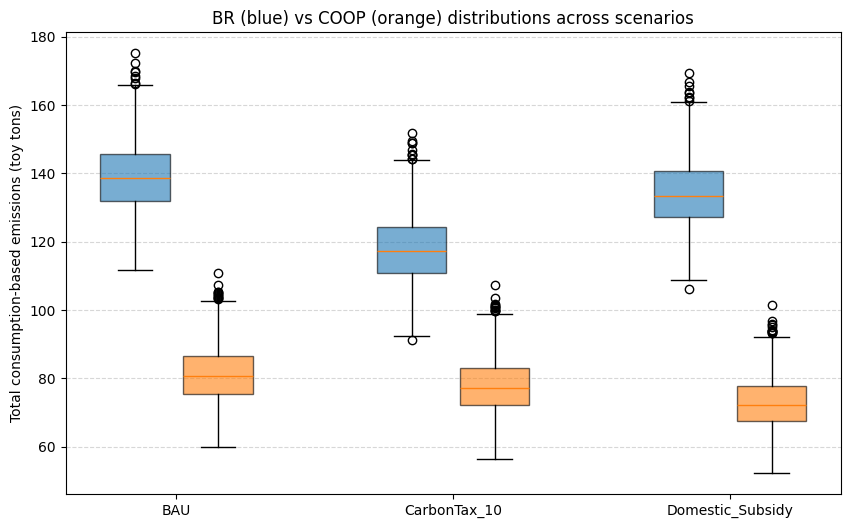

Saved total_consumption_emission_histogram.png


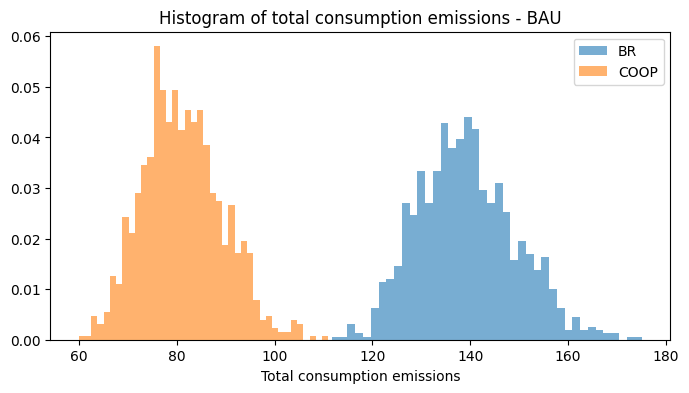

In [1]:
"""
Strategic MRIO Monte Carlo script (nonlinear & endogenous A)

Upgrades:
- Nonlinear abatement cost: C_i(r_i) = a_i * (e0_i * r_i)^2 / (1 - r_i + eps)
- Endogenous trade shares: A(r) = row-normalized( A_base * (1 + beta * r) column-wise )
- Nonlinear global damage: D(E) = kappa * E**eta  with eta > 1 (default 1.6)
- BR solved by iterated single-agent scalar optimizations (coupled via A(r) and D(E))
- Cooperative planner includes SCC, abatement cost, subsidy cost (weighted), carbon tax, and nonlinear damage
- Monte Carlo default M=1000
"""

import numpy as np
from scipy.optimize import minimize_scalar, minimize
import matplotlib.pyplot as plt
from tqdm import trange
import platform

# ---------------------------
# Synthetic base data
# ---------------------------
def make_synthetic_data(kappa=0.05, eta=1.6):
    J_dom = 4
    K_foreign = 3
    n_players = J_dom + K_foreign

    e0_dom = np.array([10.0,  6.0,  8.0,  4.0])
    e0_foreign = np.array([30.0, 50.0, 40.0])
    e0 = np.concatenate([e0_dom, e0_foreign])

    # square (n x n) MRIO: rows = consumers, cols = producers
    A_base = np.zeros((n_players, n_players))
    dom_share = 0.6
    for j in range(J_dom):
        A_base[j, :J_dom] = dom_share / J_dom
        A_base[j, J_dom:] = (1 - dom_share) / K_foreign
    # copy the same pattern to foreign consumer rows (toy)
    for j in range(J_dom, n_players):
        A_base[j, :] = A_base[j % J_dom, :]

    c_dom = np.array([100.0, 80.0, 120.0, 60.0])  # not directly used in this toy

    a = np.concatenate([np.array([1.0, 1.2, 0.9, 1.5]),
                        np.array([0.8, 1.1, 1.3])])
    s = np.zeros(n_players)
    r0 = np.zeros(n_players)

    # damage internalization shares (who feels global damage fraction)
    gamma = np.ones(n_players) / n_players  # uniform by default

    # params for new pieces
    beta = 0.6   # strength of green preference in trade matrix A(r)
    eps = 1e-6   # numerical guard for cost near r=1

    return {
        "J_dom": J_dom, "K_foreign": K_foreign, "n": n_players,
        "e0": e0, "A_base": A_base, "c_dom": c_dom, "a": a, "s": s, "r0": r0,
        "gamma": gamma, "kappa": kappa, "eta": eta, "beta": beta, "eps": eps
    }

# ---------------------------
# Endogenous A(r) + accounting
# ---------------------------
def A_endogenous(A_base, r, beta):
    """
    Column-scale A_base by (1 + beta * r_i) and renormalize each row to sum to 1.
    """
    scale = (1.0 + beta * r)  # shape (n,)
    A_scaled = A_base * scale[np.newaxis, :]  # column-wise scaling via broadcast
    row_sums = A_scaled.sum(axis=1, keepdims=True)
    # guard against zero rows
    row_sums[row_sums == 0] = 1.0
    return A_scaled / row_sums

def consumption_based_emissions(e0, r, A_base, beta, c_dom=None):
    """
    Uses endogenous A(r). Returns (cons_by_consumer, total_cons_em, e_prod, A_r)
    """
    A_r = A_endogenous(A_base, r, beta)
    e_prod = e0 * (1 - r)
    cons_by_consumer = A_r.dot(e_prod)
    total_cons_em = cons_by_consumer.sum()
    return cons_by_consumer, total_cons_em, e_prod, A_r

# ---------------------------
# Payoffs including nonlinear cost & damage with A(r)
# ---------------------------
def player_payoffs(e0, r, A_base, a, s, gamma, kappa, eta, beta,
                   carbon_tax=0.0, import_tariff=None, eps=1e-6):
    n = len(e0)
    cons_by_consumer, total_cons_em, e_prod, A_r = consumption_based_emissions(e0, r, A_base, beta)
    # emissions assigned to each producer = e_prod * column_sums(A_r)
    col_sums = A_r.sum(axis=0)
    assigned = e_prod * col_sums

    # Nonlinear abatement cost (blows up near r->1)
    C = a * (e0 * r)**2 / (1.0 - r + eps)

    # Subsidy paid per unit abatement output (kept linear in r for clarity)
    P = s * (e0 * r)

    # Carbon tax on assigned production emissions
    T = np.zeros(n)
    if carbon_tax and carbon_tax != 0.0:
        T += carbon_tax * assigned
    if import_tariff is not None:
        T += import_tariff * assigned

    # Nonlinear global damage, each player internalizes gamma_i share
    damage = kappa * (total_cons_em ** eta)   # scalar
    D_vec = gamma * damage

    U = -C + P - T - D_vec
    return U, assigned, total_cons_em, C.sum(), P.sum(), T.sum(), D_vec.sum(), A_r

def carbon_tax_term(e0, r, A_base, beta, carbon_tax=0.0):
    if carbon_tax == 0.0:
        return 0.0
    _, _, e_prod, A_r = consumption_based_emissions(e0, r, A_base, beta)
    assigned = e_prod * A_r.sum(axis=0)
    return carbon_tax * assigned.sum()

# ---------------------------
# Best-response solver (iterated BR)
# ---------------------------
def best_response_nash(e0, A_base, a, s, gamma, kappa, eta, beta,
                       r0=None, carbon_tax=0.0, import_tariff=None,
                       max_iters=600, tol=1e-6, verbose=False, eps=1e-6):
    n = len(e0)
    r = np.zeros(n) if r0 is None else r0.copy()
    history = [r.copy()]
    upper = 1.0 - 1e-6  # avoid singular cost at 1

    for it in range(max_iters):
        r_old = r.copy()
        for i in range(n):
            def neg_util_single(ri):
                r_temp = r.copy()
                r_temp[i] = ri
                U, *_ = player_payoffs(
                    e0, r_temp, A_base, a, s, gamma, kappa, eta, beta,
                    carbon_tax, import_tariff, eps=eps
                )
                return -float(U[i])
            res = minimize_scalar(neg_util_single, bounds=(0.0, upper),
                                  method='bounded', options={'xatol':1e-6})
            r[i] = float(res.x)
        history.append(r.copy())
        if np.linalg.norm(r - r_old) < tol:
            break

    U, assigned, total_cons_em, Csum, Psum, Tsum, Dsum, A_r = player_payoffs(
        e0, r, A_base, a, s, gamma, kappa, eta, beta, carbon_tax, import_tariff, eps=eps
    )
    return r, U, assigned, total_cons_em, Csum, Psum, Tsum, Dsum, np.array(history), A_r

# ---------------------------
# Cooperative solver (social planner)
# ---------------------------
def cooperative_solution(e0, A_base, a, s, gamma, kappa, eta, beta,
                         carbon_tax=0.0, weight_cost=1.0, SCC=50.0,
                         subsidy_effect=0.0, subsidy_cost_weight=1.0,
                         eps=1e-6):
    """
    - a_eff = a * (1 - subsidy_effect * s) (optional)
    - Planner objective:  SCC*E_total + weight_cost*Cost + subsidy_cost_weight*Subsidy + carbon_tax_term + Damage(E)
    """
    n = len(e0)
    a_eff = a * (1 - subsidy_effect * s)
    upper = 1.0 - 1e-6

    def obj(r_vec):
        r_vec = np.clip(r_vec, 0.0, upper)
        _, total_cons_em, _, _ = consumption_based_emissions(e0, r_vec, A_base, beta)
        cost = np.sum(a_eff * (e0 * r_vec)**2 / (1.0 - r_vec + eps))
        subsidy_cost = np.sum(s * (e0 * r_vec))
        tax_term = carbon_tax_term(e0, r_vec, A_base, beta, carbon_tax=carbon_tax)
        damage = kappa * (total_cons_em ** eta)
        return (SCC * total_cons_em
                + weight_cost * cost
                + subsidy_cost_weight * subsidy_cost
                + tax_term
                + damage)

    bounds = [(0.0, upper)] * n
    res = minimize(obj, np.zeros(n), bounds=bounds, method='SLSQP',
                   options={'ftol':1e-7, 'maxiter':1200})
    r_opt = np.clip(res.x, 0.0, upper)

    # report components at optimum (use a_eff for cost in reporting consistency)
    U, assigned, total_cons_em, _, Psum, Tsum, Dsum, A_r = player_payoffs(
        e0, r_opt, A_base, a_eff, s, gamma, kappa, eta, beta, carbon_tax, eps=eps
    )
    # recompute cost with a_eff to return an aggregate cost number
    Csum = np.sum(a_eff * (e0 * r_opt)**2 / (1.0 - r_opt + eps))
    return r_opt, assigned, total_cons_em, Csum, Psum, Tsum, Dsum, res, A_r

# ---------------------------
# Sampling helpers (lognormal)
# ---------------------------
def lognormal_params_from_mean_std(mean, rel_std):
    sigma_rel = max(1e-12, rel_std)
    sigma_log = np.sqrt(np.log(1 + sigma_rel**2))
    mu_log = np.log(mean) - 0.5 * sigma_log**2
    return mu_log, sigma_log

def sample_parameters(base_e0, base_a, sigma_e0=0.15, sigma_a=0.35, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    mu_e, s_e = lognormal_params_from_mean_std(base_e0, sigma_e0)
    e0_sample = rng.lognormal(mean=mu_e, sigma=s_e, size=base_e0.shape)
    mu_a, s_a = lognormal_params_from_mean_std(base_a, sigma_a)
    a_sample = rng.lognormal(mean=mu_a, sigma=s_a, size=base_a.shape)
    return e0_sample, a_sample

# ---------------------------
# Monte Carlo runner (default M=1000)
# ---------------------------
def monte_carlo_uncertainty(num_draws=1000, sigma_e0=0.15, sigma_a=0.35, scenarios=None,
                            verbose=True, seed=12345, subsidy_effect=0.6, subsidy_cost_weight=0.05,
                            kappa_override=None, eta_override=None, beta_override=None):
    print("=== Monte Carlo settings ===")
    print(f"num_draws = {num_draws}, seed = {seed}")
    print(f"sigma_e0 = {sigma_e0}, sigma_a = {sigma_a}")
    print(f"subsidy_effect = {subsidy_effect}, subsidy_cost_weight = {subsidy_cost_weight}")
    print(f"CI method = empirical percentile (2.5%,97.5%)")
    print(f"Python {platform.python_version()}, numpy {np.__version__}")
    print("============================\n")

    data = make_synthetic_data()
    base_e0 = data["e0"]; base_a = data["a"]
    A_base = data["A_base"]; s_base = data["s"]; r0 = data["r0"]
    gamma = data["gamma"]; kappa = data["kappa"]; eta = data["eta"]
    beta = data["beta"]; eps = data["eps"]
    n = data["n"]

    if kappa_override is not None: kappa = kappa_override
    if eta_override is not None:   eta = eta_override
    if beta_override is not None:  beta = beta_override

    rng = np.random.default_rng(seed)

    if scenarios is None:
        scenarios = {
            "BAU": {"carbon_tax": 0.0, "s": np.zeros(n), "SCC": 50.0},
            "CarbonTax_10": {"carbon_tax": 10.0, "s": np.zeros(n), "SCC": 50.0},
            "Domestic_Subsidy": {
                "carbon_tax": 0.0,
                "s": np.concatenate([np.ones(data["J_dom"])*1.5, np.zeros(n-data["J_dom"])]),
                "SCC": 50.0
            },
        }

    results = {name: {"BR_total": [], "COOP_total": [], "BR_r": [], "COOP_r": []}
               for name in scenarios.keys()}

    iters = trange(num_draws, desc="MC draws") if verbose else range(num_draws)
    for _ in iters:
        e0_samp, a_samp = sample_parameters(base_e0, base_a, sigma_e0=sigma_e0, sigma_a=sigma_a, rng=rng)
        for name, params in scenarios.items():
            s_local   = params.get("s", np.zeros(n))
            carbon_tx = params.get("carbon_tax", 0.0)
            SCC       = params.get("SCC", 50.0)

            # Best-response (strategic because of A(r) and D(E))
            r_br, U_br, assigned_br, total_br, Cbr, Pbr, Tbr, Dbr, hist, A_r_br = best_response_nash(
                e0_samp, A_base, a_samp, s_local, gamma, kappa, eta, beta,
                r0=None, carbon_tax=carbon_tx, import_tariff=None,
                max_iters=600, tol=1e-6, verbose=False
            )

            # Cooperative planner
            r_coop, assigned_coop, total_coop, Ccoop, Pcoop, Tcoop, Dcoop, res, A_r_coop = cooperative_solution(
                e0_samp, A_base, a_samp, s_local, gamma, kappa, eta, beta,
                carbon_tax=carbon_tx, weight_cost=1.0, SCC=SCC,
                subsidy_effect=subsidy_effect, subsidy_cost_weight=subsidy_cost_weight
            )

            results[name]["BR_total"].append(total_br)
            results[name]["COOP_total"].append(total_coop)
            results[name]["BR_r"].append(r_br)
            results[name]["COOP_r"].append(r_coop)

    # to arrays
    for name in results:
        results[name]["BR_total"]  = np.array(results[name]["BR_total"])
        results[name]["COOP_total"] = np.array(results[name]["COOP_total"])
        results[name]["BR_r"]      = np.stack(results[name]["BR_r"], axis=0)
        results[name]["COOP_r"]    = np.stack(results[name]["COOP_r"], axis=0)

    np.savez("mc_results_snapshot.npz", results=results, seed=seed, num_draws=num_draws,
             sigma_e0=sigma_e0, sigma_a=sigma_a, subsidy_effect=subsidy_effect,
             subsidy_cost_weight=subsidy_cost_weight, kappa=kappa, eta=eta, beta=beta)
    print("Saved mc_results_snapshot.npz\n")
    return results

# ---------------------------
# Plot & summarize
# ---------------------------
def summarize_and_plot_mc(results, save_figs=True, ci_method="percentile"):
    scenario_names = list(results.keys())

    # Summary + CI
    for name in scenario_names:
        br = results[name]["BR_total"]
        coop = results[name]["COOP_total"]
        M = br.size
        if ci_method == "percentile":
            br_ci = np.percentile(br, [2.5, 97.5])
            coop_ci = np.percentile(coop, [2.5, 97.5])
        else:
            br_se = br.std(ddof=1)/np.sqrt(M)
            coop_se = coop.std(ddof=1)/np.sqrt(M)
            br_ci = (br.mean() - 1.96*br_se, br.mean() + 1.96*br_se)
            coop_ci = (coop.mean() - 1.96*coop_se, coop.mean() + 1.96*coop_se)

        print(f"\nScenario {name}:")
        print(f" BR mean={br.mean():.3f}, std={br.std():.3f}, 2.5%={br_ci[0]:.3f}, 97.5%={br_ci[1]:.3f}")
        print(f" Coop mean={coop.mean():.3f}, std={coop.std():.3f}, 2.5%={coop_ci[0]:.3f}, 97.5%={coop_ci[1]:.3f}")

    # Boxplot: BR vs COOP
    fig, ax = plt.subplots(figsize=(10,6))
    br_data = [results[n]["BR_total"] for n in scenario_names]
    coop_data = [results[n]["COOP_total"] for n in scenario_names]
    positions_br = np.arange(len(scenario_names))*2.0 - 0.3
    positions_coop = np.arange(len(scenario_names))*2.0 + 0.3
    ax.boxplot(br_data, positions=positions_br, widths=0.5, patch_artist=True,
               boxprops=dict(facecolor='C0', alpha=0.6))
    ax.boxplot(coop_data, positions=positions_coop, widths=0.5, patch_artist=True,
               boxprops=dict(facecolor='C1', alpha=0.6))
    ax.set_xticks(np.arange(len(scenario_names))*2.0)
    ax.set_xticklabels(scenario_names)
    ax.set_ylabel("Total consumption-based emissions (toy tons)")
    ax.set_title("BR (blue) vs COOP (orange) distributions across scenarios")
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    if save_figs:
        fig.savefig("br_vs_coop_distribution.png", dpi=300, bbox_inches='tight')
        print("Saved br_vs_coop_distribution.png")
    plt.show()

    # Histograms for first scenario
    first = scenario_names[0]
    plt.figure(figsize=(8,4))
    plt.hist(results[first]["BR_total"], bins=40, alpha=0.6, label='BR', density=True)
    plt.hist(results[first]["COOP_total"], bins=40, alpha=0.6, label='COOP', density=True)
    plt.legend()
    plt.title(f"Histogram of total consumption emissions - {first}")
    plt.xlabel("Total consumption emissions")
    if save_figs:
        plt.savefig("total_consumption_emission_histogram.png", dpi=300, bbox_inches='tight')
        print("Saved total_consumption_emission_histogram.png")
    plt.show()

# ---------------------------
# Convergence diagnostic helper
# ---------------------------
def convergence_diagnostic(M_list=[200,500,1000,2000], sigma_e0=0.15, sigma_a=0.35, seed=12345):
    print("Running convergence diagnostic for different M values:")
    for M in M_list:
        results = monte_carlo_uncertainty(num_draws=M, sigma_e0=sigma_e0, sigma_a=sigma_a,
                                          verbose=False, seed=seed)
        br_mean = results["BAU"]["BR_total"].mean()
        br_ci = np.percentile(results["BAU"]["BR_total"], [2.5,97.5])
        print(f" M={M:5d} | BAU BR mean={br_mean:.3f} | CI=[{br_ci[0]:.3f},{br_ci[1]:.3f}]")

# ---------------------------
# If run as script
# ---------------------------
if __name__ == "__main__":
    # Example run: M=1000
    M = 1000
    seed = 12345
    sigma_e0 = 0.15
    sigma_a = 0.35
    subsidy_effect = 0.6
    subsidy_cost_weight = 0.05

    # nonlinear damage & endogenous A intensity (tweak if needed)
    kappa_override = 0.05
    eta_override   = 1.6
    beta_override  = 0.6

    results = monte_carlo_uncertainty(
        num_draws=M, sigma_e0=sigma_e0, sigma_a=sigma_a,
        verbose=True, seed=seed, subsidy_effect=subsidy_effect,
        subsidy_cost_weight=subsidy_cost_weight,
        kappa_override=kappa_override, eta_override=eta_override,
        beta_override=beta_override
    )
    summarize_and_plot_mc(results, save_figs=True, ci_method="percentile")

    # optional: convergence_diagnostic([200,500,1000], sigma_e0=sigma_e0, sigma_a=sigma_a, seed=seed)
